# <span style="color:#5B5EA6">What moves us?</span>

We all have been involved, in many different ways, with COVID and we all know how does it fell to be powerless in front of such a cathastrophe.. So what if for a moment we forget about the current situation? What if all of that didn't happen?... 

## <span style="color:#00A170">Our Goal<span>

Our objective is to answer the question:

- If COVID was not a thing, what would the current Job Market situation be?

The analysis focuses on two Job Areas which involve (more or less direclty) ourselves:

- Public Sanity
- Scientific and Technical Industry

### <span style="color:#00A170">Furthermore...</span>

We want to bring attention to the whole class of Workers which are over 40 yrs old.
- They are the ones who are more fraglie and who risk more than yougsters because they probably have duties others do not have..

In [ ]:
# Importazione delle librerie
#!pip install statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import datetime as datetime
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

# Import

In [ ]:
# Importazione dei dataset
df_attivati = pd.read_csv("/Users/mac-josh/Desktop/DataScience/Esame/RapportiAttivati.csv")
df_cessati = pd.read_csv("/Users/mac-josh/Desktop/DataScience/Esame/RapportiCessati.csv")

# Definizione funzioni

In [ ]:
# Permette di importare e pulire il Dataset dei codici ateco
def Import_And_Clean_Ateco():
    
    # Lettura Dataset contenente i codici ateco
    df_ateco = pd.read_csv("/Users/mac-josh/Desktop/DataScience/Esame/Codici_Ateco.csv")
    #df_ateco = pd.read_csv("/content/drive/MyDrive/Data Science/Codici_Ateco.csv")
    
    # Rimozione del codice ateco dalla descrizione Ateco
    for Index in range(len(df_ateco["Codice_ateco"])):
        df_ateco["Descrizione_ateco"][Index] = df_ateco["Descrizione_ateco"][Index][len(df_ateco["Codice_ateco"][Index])+2:len(df_ateco["Descrizione_ateco"][Index])]
    
        # Rimozione dello spazio iniziale
        df_ateco["Descrizione_ateco"][Index] = df_ateco["Descrizione_ateco"][Index].strip()
    
    # Drop della colonna id perchè non serve
    df_ateco = df_ateco.drop("_id",axis=1)
    
    # Rinominazione della colonna della descrizione per fare successivamente il join
    df_ateco.rename(columns = {"Descrizione_ateco":"SETTOREECONOMICODETTAGLIO"}, inplace = True)
    
    # Lower case di tutta la colonna del settore economico per fare la join con gli altri dataset
    df_ateco["SETTOREECONOMICODETTAGLIO"] = df_ateco["SETTOREECONOMICODETTAGLIO"].str.lower()
    
    # Rimozione dei codici duplicati (dataset corrotto?)
    df_ateco.drop_duplicates(subset="SETTOREECONOMICODETTAGLIO",keep="first",inplace=True)
    
    return df_ateco    

In [ ]:
# Questa funzione permette di eseguire la LeftJoin tra i dataset Over40After2017 con 
# il dataset dei codici ateco. Secondo step è quello di estrapolare MacroCategoria e 
# Hyper Categoria dai codici ateco, questo ci permette un raggruppamento migliore
def Join_Ateco_DF(df):
    
    # Lower case di tutta la colonna del settore economico per fare la join con l'altro dataset
    df["SETTOREECONOMICODETTAGLIO"] = df["SETTOREECONOMICODETTAGLIO"].str.lower() 
    
    # Merge dei dataset per colonna settore economico dettaglio
    df = df.merge(df_ateco,on="SETTOREECONOMICODETTAGLIO",how="left")
    
    # Controllo sui valori nulli (non tutti i settori economici hanno un codice ateco)
    ## Ne rimangono fuori circa 35mila --> soluzione --> Dare un codice speciale a quelli che non l'hanno
    ### Introduzione di un codice speciale per i valori che hanno dati mancanti
    df["Codice_ateco"].fillna("99",inplace=True)
    
    # Creazione della nuova colonna che introduce la macro categoria
    df["MACRO_CATEGORIA_ATECO"] = ""
    
    # Estrapola la macro categoria Ateco (Series) (con una lambda perchè non ho 51 secoli)
    macro_ateco = df.apply(lambda df: df['Codice_ateco'][:2], axis=1)
    
    # Setta i valori della serie nella colonna
    df["MACRO_CATEGORIA_ATECO"] = macro_ateco
    
    # Creazione della nuova colonna che introduce la Hyper categoria
    df["HYPER_CATEGORIA_ATECO"] = ""
    
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "01", "HYPER_CATEGORIA_ATECO"] = "A"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "02", "HYPER_CATEGORIA_ATECO"] = "A"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "03", "HYPER_CATEGORIA_ATECO"] = "A"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "05", "HYPER_CATEGORIA_ATECO"] = "B"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "06", "HYPER_CATEGORIA_ATECO"] = "B"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "07", "HYPER_CATEGORIA_ATECO"] = "B"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "08", "HYPER_CATEGORIA_ATECO"] = "B"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "09", "HYPER_CATEGORIA_ATECO"] = "B"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "10", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "11", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "12", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "13", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "14", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "15", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "16", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "17", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "18", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "19", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "20", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "21", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "22", "HYPER_CATEGORIA_ATECO"] = "C" 
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "23", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "24", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "25", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "26", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "27", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "28", "HYPER_CATEGORIA_ATECO"] = "C" 
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "29", "HYPER_CATEGORIA_ATECO"] = "C" 
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "30", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "31", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "32", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "33", "HYPER_CATEGORIA_ATECO"] = "C"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "35", "HYPER_CATEGORIA_ATECO"] = "D"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "36", "HYPER_CATEGORIA_ATECO"] = "E"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "37", "HYPER_CATEGORIA_ATECO"] = "E"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "38", "HYPER_CATEGORIA_ATECO"] = "E"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "39", "HYPER_CATEGORIA_ATECO"] = "E"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "41", "HYPER_CATEGORIA_ATECO"] = "F"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "42", "HYPER_CATEGORIA_ATECO"] = "F"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "43", "HYPER_CATEGORIA_ATECO"] = "F"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "45", "HYPER_CATEGORIA_ATECO"] = "G"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "46", "HYPER_CATEGORIA_ATECO"] = "G"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "47", "HYPER_CATEGORIA_ATECO"] = "G"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "49", "HYPER_CATEGORIA_ATECO"] = "H"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "50", "HYPER_CATEGORIA_ATECO"] = "H"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "51", "HYPER_CATEGORIA_ATECO"] = "H"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "52", "HYPER_CATEGORIA_ATECO"] = "H"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "53", "HYPER_CATEGORIA_ATECO"] = "H"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "55", "HYPER_CATEGORIA_ATECO"] = "I"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "56", "HYPER_CATEGORIA_ATECO"] = "I"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "58", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "59", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "60", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "61", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "62", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "63", "HYPER_CATEGORIA_ATECO"] = "J"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "64", "HYPER_CATEGORIA_ATECO"] = "K"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "65", "HYPER_CATEGORIA_ATECO"] = "K" 
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "66", "HYPER_CATEGORIA_ATECO"] = "K"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "68", "HYPER_CATEGORIA_ATECO"] = "L"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "69", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "70", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "71", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "72", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "73", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "74", "HYPER_CATEGORIA_ATECO"] = "M" 
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "75", "HYPER_CATEGORIA_ATECO"] = "M"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "77", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "78", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "79", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "80", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "81", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "82", "HYPER_CATEGORIA_ATECO"] = "N"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "84", "HYPER_CATEGORIA_ATECO"] = "O"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "85", "HYPER_CATEGORIA_ATECO"] = "P"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "86", "HYPER_CATEGORIA_ATECO"] = "Q"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "87", "HYPER_CATEGORIA_ATECO"] = "Q"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "88", "HYPER_CATEGORIA_ATECO"] = "Q"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "90", "HYPER_CATEGORIA_ATECO"] = "R"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "91", "HYPER_CATEGORIA_ATECO"] = "R"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "92", "HYPER_CATEGORIA_ATECO"] = "R"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "93", "HYPER_CATEGORIA_ATECO"] = "R"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "94", "HYPER_CATEGORIA_ATECO"] = "S"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "95", "HYPER_CATEGORIA_ATECO"] = "S"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "96", "HYPER_CATEGORIA_ATECO"] = "S"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "97", "HYPER_CATEGORIA_ATECO"] = "T"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "98", "HYPER_CATEGORIA_ATECO"] = "T"
    df.loc[df["MACRO_CATEGORIA_ATECO"] == "99", "HYPER_CATEGORIA_ATECO"] = "U"
    
    return df

In [ ]:
# Funzione che permette di raggruppare i titoli di studio in 4 livelli
def Grouping_Titolo_Studio(df):

    # Creazione della nuova colonna che introduce il livello di studio
    df["LIVELLO_STUDIO"] = ""
    
    df.loc[df["TITOLOSTUDIO"] == "NESSUN TITOLO DI STUDIO", "GRUPPO_TITOLO_STUDIO"] = "Basso"
    df.loc[df["TITOLOSTUDIO"] == "LICENZA ELEMENTARE", "GRUPPO_TITOLO_STUDIO"] = "Basso"
    df.loc[df["TITOLOSTUDIO"] == "LICENZA MEDIA", "GRUPPO_TITOLO_STUDIO"] = "Basso"
        
    df.loc[df["TITOLOSTUDIO"] == "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CHE PERMETTE L'ACCESSO ALL'UNIVERSITA", "GRUPPO_TITOLO_STUDIO"] = "Medio"
    df.loc[df["TITOLOSTUDIO"] == "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()", "GRUPPO_TITOLO_STUDIO"] = "Medio"
    df.loc[df["TITOLOSTUDIO"] == "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CHE PERMETTE L'ACCESSO ALL'UNIVERSITA", "GRUPPO_TITOLO_STUDIO"] = "Medio"
    
    
    df.loc[df["TITOLOSTUDIO"] == "DIPLOMA DI SPECIALIZZAZIONE", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "DIPLOMA UNIVERSITARIO", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "LAUREA - Vecchio o nuovo ordinamento", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "MASTER UNIVERSITARIO DI PRIMO LIVELLO", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "TITOLO DI DOTTORE DI RICERCA", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    df.loc[df["TITOLOSTUDIO"] == "TITOLO DI STUDIO POST-LAUREA", "GRUPPO_TITOLO_STUDIO"] = "Alto"
    
    return df
    

In [ ]:
# Funzione che permette di rimpieri i valori nulli riguardo al Gruppo titolo di studio
## Impostiamo come gruppo "Medio" perchè in origine doveva essere questo 
def Fill_Null_Gruppo_Titolo_Studio(df):
    
    df.loc[df["GRUPPO_TITOLO_STUDIO"].isna(), "GRUPPO_TITOLO_STUDIO"] = "Medio"
    return df
    

In [ ]:
# Funzione che permette di associare una categoria Ateco ad un Titolo
def Print_Category(parCat):
    retString = ""
    
    if(parCat == "A"):
        retString = "AGRICOLTURA, SILVICOLTURA E PESCA"
    elif(parCat == "B"):
        retString = "ESTRAZIONE DI MINERALI DA CAVE E MINIERE"
    elif(parCat == "C"):
        retString = "ATTIVITÀ MANIFATTURIERE"
    elif(parCat == "D"):
        retString = "FORNITURA DI ENERGIA ELETTRICA, GAS, VAPORE E ARIA CONDIZIONATA"
    elif(parCat == "E"):
        retString = "FORNITURA DI ACQUA; RETI FOGNARIE, ATTIVITÀ DI GESTIONE DEI RIFIUTI E RISANAMENTO"
    elif(parCat == "F"):
        retString = "COSTRUZIONI"
    elif(parCat == "G"):
        retString = "COMMERCIO ALL'INGROSSO E AL DETTAGLIO; RIPARAZIONE DI AUTOVEICOLI E MOTOCICLI"
    elif(parCat == "H"):
        retString = "TRASPORTO E MAGAZZINAGGIO"
    elif(parCat == "I"):
        retString = "ATTIVITÀ DEI SERVIZI DI ALLOGGIO E DI RISTORAZIONE"
    elif(parCat == "J"):
        retString = "SERVIZI DI INFORMAZIONE E COMUNICAZIONE"
    elif(parCat == "K"):
        retString = "ATTIVITÀ FINANZIARIE E ASSICURATIVE"
    elif(parCat == "L"):
        retString = "ATTIVITA' IMMOBILIARI"
    elif(parCat == "M"):
        retString = "ATTIVITÀ PROFESSIONALI, SCIENTIFICHE E TECNICHE"
    elif(parCat == "N"):
        retString = "NOLEGGIO, AGENZIE DI VIAGGIO, SERVIZI DI SUPPORTO ALLE IMPRESE"
    elif(parCat == "O"):
        retString = "AMMINISTRAZIONE PUBBLICA E DIFESA; ASSICURAZIONE SOCIALE OBBLIGATORIA"
    elif(parCat == "P"):
        retString = "ISTRUZIONE"
    elif(parCat == "Q"):
        retString = "SANITA' E ASSISTENZA SOCIALE"
    elif(parCat == "R"):
        retString = "ATTIVITÀ ARTISTICHE, SPORTIVE, DI INTRATTENIMENTO E DIVERTIMENTO"
    elif(parCat == "S"):
        retString = "ALTRE ATTIVITÀ DI SERVIZI"
    elif(parCat == "T"):
        retString = "PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI PER USO PROPRIO DA PARTE DI FAMIGLIE E CONVIVENZE"
    elif(parCat == "U"):
        retString = "ORGANIZZAZIONI ED ORGANISMI EXTRATERRITORIALI"
                                                                            
    return retString        

In [ ]:
# Permette di stampare il grafico che mostra il trend
def Plot_Trend_Globale(df):
    
    # Cicla sulle categorie
    for j,k in enumerate(df["HYPER_CATEGORIA_ATECO"].unique()):
        Plot_Trend(df,k)
    
    return (None)

In [ ]:
def Plot_Trend(df,parCategoria):
    # Estrazione dei singoli anni
    years = df['ANNO'].unique()

    # Prepazione dei colori
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

    # Stampa grafico
    plt.figure(figsize=(10,5), dpi= 80)
    for i, y in enumerate(years):
        if i > 0:        
            plt.plot('MESE', 'VALUE', data=df.loc[(df["ANNO"]==y) & (df["HYPER_CATEGORIA_ATECO"]==parCategoria)], color=mycolors[i], label=y)
            plt.title(Print_Category(parCategoria))
            plt.text(df.loc[(df["ANNO"]==y) & (df["HYPER_CATEGORIA_ATECO"]==parCategoria), :].shape[0]-.9, df.loc[(df["ANNO"]==y) & (df["HYPER_CATEGORIA_ATECO"]==parCategoria), 'VALUE'][-1:].values[0], y, fontsize=12, color=mycolors[i])

    plt.show()
    
    return(None)

In [ ]:
# Restituisce il p_value della serie per verificarne la stazionarietà
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
def plot_stationarity(df_value):  
    # Original Series
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df_value.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df_value.diff().diff().dropna(), ax=axes[2, 1])

    fig.tight_layout()
    return plt.show()

In [ ]:
# Restituisce un DataSet filtrato per categoria, nella forma richiesta per lo studio seguente
def Prep_Dataset(df, parCat, parValueToBeRemoved):
    
    df_transformed  = df.drop(columns={"ANNO","MESE",parValueToBeRemoved})
    df_transformed_cat = df_transformed.loc[df_transformed["HYPER_CATEGORIA_ATECO"] == parCat]
    df_transformed_cat.drop(columns={"HYPER_CATEGORIA_ATECO"},inplace=True)
    df_transformed_cat.set_index("DATA",inplace=True)
    
    return df_transformed_cat

In [ ]:
# Funzione che permette di plottare le componenti della seasonality
# Questo ci permette di capire con quale tipo di time series abbiamo a che fare
def Studio_Seasonality(df,parPeriod,parTrendType):
    
    # Multiplicative Decomposition
    result_mul = seasonal_decompose(df[parTrendType], model='multiplicative', extrapolate_trend='freq', period = parPeriod)
    # Additive Decomposition
    result_add = seasonal_decompose(df[parTrendType], model='additive', extrapolate_trend='freq', period = parPeriod)
    plt.rcParams.update({'figure.figsize': (8,8)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
    result_add.plot().suptitle('Additive Decompose', fontsize=22)
    
    return plt

In [ ]:
#
def Studio_Arima(parDF,parColumn):

    arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

    i=0
    # Loop over p values from 0-5
    for p in range(6):
        # Loop over q values from 0-5
        for q in range(6):

            try:
                # creating and fitting ARIMA(p,1,q) model
                model = ARIMA(parDF[parColumn].astype(float), order=(p,1,q))
                results = model.fit()

                # Printing order, AIC and BIC
                #print(p, q, results.aic, results.bic)
                arima_df.loc[i,"p"] = p
                arima_df.loc[i,"q"] = q
                arima_df.loc[i,"aic"] = results.aic
                arima_df.loc[i,"bic"] = results.bic
                i = i+1
            except:
                #print(p, q, None, None)
                i = i+1

    arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
    arima_df.sort_values(by="aic", ascending=False, inplace=True)
    return arima_df

In [ ]:
# Permette di suddividere il Dataset in dati di training e di test
def Split_df(parDf,parColumn,parTrainSize):
    # creazione test e train set
    train_size = parTrainSize
    split_idx = round(len(df_Att_Pro_Tec["VALUE_x"])* train_size)

    # Split
    train = parDf[parColumn].iloc[:split_idx]
    test = parDf[parColumn].iloc[split_idx:]

    # Visualize split
    fig,ax= plt.subplots(figsize=(6,6))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train,test

In [ ]:
def arima_model(df_value, p,d,q):
    model = ARIMA(df_value, order=(p,d,q))
    model_fit = model.fit(disp=0)
    residuals = pd.DataFrame(model_fit.resid)

    #fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    #axes[0, 0].plot(df_value)
    
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])

    model_fit.plot_predict(dynamic=False)
    model_fit.summary()
    plt.show()
    return model

In [ ]:
# Restituisce la migior impostazione per il Modello Arima
def Build_Model(parTrain,parMax_p,parMax_q,parSeasonal):
    model = auto_arima(   parTrain,
                          start_p=0,
                          start_q=0,
                          information_criterion='aic',
                          test='adf',
                          max_p=parMax_p,
                          max_q=parMax_q,
                          D=1,
                          start_P=0,
                          m = 12,
                          seasonal=parSeasonal,
                          trace=True,
                          error_action="ignore",
                          suppress_warnings=True,
                          stepwise=True,
                          verbose=1)
    return model.summary()

In [ ]:
# Esegue la predizione con modello arima
## Order1,Order2,Order3 -- L'ordine da applicare ad arima, ricavato dall'auto arima
def Predict(train,test,Order1,Order2,Order3,parForecastLenght=31):
   
    # Build Model
    model = ARIMA(train.astype("float32"), order=(Order1, Order2, Order3))  
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(parForecastLenght, alpha=0.05)  

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.iloc[0:parForecastLenght].index)
    lower_series = pd.Series(conf[:, 0], index=test.iloc[0:parForecastLenght].index)
    upper_series = pd.Series(conf[:, 1], index=test.iloc[0:parForecastLenght].index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return fc_series

In [ ]:
# Plotting Predictions
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

In [ ]:
## Permette di eseguire lo studio mediante SARIMAX
## Introdotta anche una what if analysis tra dati di test e predizione
# AO1 : Primo elemento per l'ordine di arima
# AO2 : Secondo elemento per l'ordine di arima
# AO3 : Terzo elemento per l'ordine di arima
# SO1 : Primo elemento per l'ordine di Sarima
# SO2 : Secondo elemento per l'ordine di Sarima
# SO3 : Terzo elemento per l'ordine di Sarima
def Go_Sarimax(parTrain,parTest,parColumn,parSteps=30,AO1=2,AO2=1,AO3=1,SO1=0,SO2=1,SO3=0,parSeason=12):
  
    # Costruzione del modello
    model2 = SARIMAX(parTrain, order=(AO1,AO2,AO3), seasonal_order=(SO1,SO2,SO3,parSeason))
    
    # Fitting del modello
    results = model2.fit()
    #results.summary()
    
    # Parametri per Grafico
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Creazione previsioni (con intervallo di confideza)
    forecast = results.get_forecast(steps=parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()
    return forecast

In [ ]:
# Plotta la distribuzione dei valori nulli
def Studio_Valori_Nulli():    
    null_values_attivati = df_globale[df_globale["MODALITA"] == 1].isnull().sum()
    null_values_cessati = df_globale[df_globale["MODALITA"] == 0].isnull().sum()
    print(null_values_attivati)
    print("**********************************")
    print(null_values_cessati)
    df_globale[df_globale.isna().any(axis=1)]["GENERE"].value_counts().plot.barh()
    plt.title("Distribution of gender for null values")    
    return (None)

In [ ]:
# Plotta la distribuzione del genere
def Studio_Distrib_Genere():
    scale_factor = 1.15

    fig = plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title("Gender distrubution activated contracts")
    df_globale[df_globale["MODALITA"] == 1]["GENERE"].value_counts().plot(kind="barh")
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)
    plt.xlabel("Number (mln)")
    plt.ylabel("Genre")

    plt.subplot(1,2,2)
    plt.title("Gender distrubution terminated contracts")
    df_globale[df_globale["MODALITA"] == 0]["GENERE"].value_counts().plot(kind="barh")
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)
    plt.xlabel("Number (mln)")
    plt.ylabel("Genre")
    
    return (None)

In [ ]:
# Rimuove gli outliers
def Remove_Outliers():
    ## Seleziona gli indici dei record con età maggiore di 90
    indexNames = df_globale[ df_globale["ETA"] > 90 ].index

    ## Elimina i record in base agli indici
    df_globale.drop(indexNames , inplace=True)
    
    ## Verifica che funzioni 
    print("Maximum age after removal of insignificant values: {}".format(df_globale["ETA"].max()))
    
    return (None)

In [ ]:
# Rimuove i valori nulli
def Remove_Nulls():
   
    ## Rimozione dei valori nulli studiati in precedenza
    df_globale.dropna(inplace=True)    

    return

In [ ]:
# Permette di dividere la data in 2 componenti
def Split_Date():
    
    # Estrae la colonna Anno
    df_globale["ANNO"] = pd.DatetimeIndex(df_globale['DATA']).year
    
    # Estrae la colonna Mese
    df_globale["MESE"] = pd.DatetimeIndex(df_globale['DATA']).month
    
    return (None)

In [ ]:
# Permette di estrarre i dati dei soggetti con più di 40 anni che hanno ricevuto 
# un'attivazione o una terminazione di contratto
# Stampa la distrubuzione del genere per vedere se abbiao introdotto bias
def Extract_Print_Data():
    
    ## Estrazione delle informazioni relative ai contratti attivati
    df_attivati_over_40 = df_globale.loc[(df_globale["MODALITA"] == 1) & (df_globale["ETA"] > 39)]
    
    ## Estrazione delle informazioni relative ai contratti terminati
    df_cessati_over_40 = df_globale.loc[(df_globale["MODALITA"] == 0) & (df_globale["ETA"] > 39)]
    
    ## Stampa i grafici relativi alla distribuzione del genere per entrambe le tipologie
    scale_factor = 1.15
    plt.figure(figsize=(15,7))

    plt.subplot(1,3,1)
    df_attivati_over_40["GENERE"].value_counts().plot(kind='barh')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)
    plt.xlabel("Number")
    plt.ylabel("Genre")
    plt.title("Gender distribution by contracts activated for over 40")

    plt.subplot(1,3,3)
    df_cessati_over_40["GENERE"].value_counts().plot(kind='barh')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)
    plt.xlabel("Number")
    plt.ylabel("Genre")
    plt.title("Gender distribution by contracts terminated for over 40")
    
    return df_attivati_over_40,df_cessati_over_40

In [ ]:
# Raggruppa per Settore economico
def Studio_Settore_Ecnonmico_Dettaglio():
    ## Raggruppamento per settore economico dettaglio
    attivazione_dettaglio_group = df_attivati_over_40.groupby("SETTOREECONOMICODETTAGLIO",as_index=False).count()
    terminazione_dettaglio_group = df_cessati_over_40.groupby("SETTOREECONOMICODETTAGLIO",as_index=False).count()

    attivazione_dettaglio_group = attivazione_dettaglio_group.sort_values("ETA",ascending=False,ignore_index=True).iloc[0:10]

    ## Creazione di un nuovo dataframe con colonne solo quelle necessarie per la rappresentazione con grafici
    df_settore_ecnomico = pd.DataFrame(columns=["SETTORE","NUMERO_ATTIVATI","NUMERO_TERMINATI"]) 

    for index in range(len(attivazione_dettaglio_group)):
        for index2 in range(len(terminazione_dettaglio_group)):
            if(attivazione_dettaglio_group["SETTOREECONOMICODETTAGLIO"][index] == terminazione_dettaglio_group["SETTOREECONOMICODETTAGLIO"][index2]):
                df_settore_ecnomico = df_settore_ecnomico.append({"SETTORE":attivazione_dettaglio_group["SETTOREECONOMICODETTAGLIO"][index],"NUMERO_ATTIVATI":attivazione_dettaglio_group["ETA"][index],"NUMERO_TERMINATI":terminazione_dettaglio_group["ETA"][index2]},ignore_index=True)

    return(df_settore_ecnomico)

In [ ]:
def Group_Activate():
    # Creazione del dataset dei contratti attivati suddivisi per Categoria/Anno/Mese
    df_grouped_attivati = pd.DataFrame(df_attivati_over_40.groupby(["HYPER_CATEGORIA_ATECO","ANNO","MESE"]).size())
    df_grouped_attivati.reset_index(inplace=True)
    df_grouped_attivati.rename(columns={0:"VALUE"},inplace=True)
    df_grouped_attivati
    
    return df_grouped_attivati

In [ ]:
def Group_DeActivate():
    # Creazione del dataset dei contratti cessati suddivisi per Categoria/Anno/Mese
    df_grouped_cessati = pd.DataFrame(df_cessati_over_40.groupby(["HYPER_CATEGORIA_ATECO","ANNO","MESE"]).size())
    df_grouped_cessati.reset_index(inplace=True)
    df_grouped_cessati.rename(columns={0:"VALUE"},inplace=True)
    df_grouped_cessati
    
    return df_grouped_cessati

In [ ]:
# Permette di filtrare il dataset per anno (dall'anno in avanti anno esclulo)
def Filter_Dataset(parDataset,parCutYear):
    
    parDataset =  parDataset[parDataset["ANNO"] > parCutYear]
    
    return parDataset

In [ ]:
# Permette di creare il dataset già filtrato e raggruppato
# Imposta come indice la data; questo ci permetterà di fare TimeSeries Forecasting
def Create_Category_Dataset():
    
    # Merging Dataset
    new_df = pd.merge(df_grouped_attivati, df_grouped_cessati,  how='left', left_on=['HYPER_CATEGORIA_ATECO','ANNO',"MESE"], right_on = ['HYPER_CATEGORIA_ATECO','ANNO',"MESE"])

    # Creazione del DataSet relativo alle categorie scelte
    new_df = new_df.loc[(new_df["HYPER_CATEGORIA_ATECO"]== "M") | (new_df["HYPER_CATEGORIA_ATECO"]== "Q")]
    
    # Introduzione della colonna Data in quanto sarà necessaria nella prossima fase di analisi
    new_df["DATA"] = ""
    new_df["DATA"] = pd.to_datetime((new_df["ANNO"]*10000+new_df["MESE"]*100+1).apply(str),format='%Y%m%d')
    
    # Impostazione dell'indice sulla colonna data
    new_df.set_index("DATA")
    
    return new_df

In [ ]:
def R2_Score(parTest,parPred):
    print(r2_score(parTest,parPred))
    return (None)

In [ ]:
def SQMSE(parTest,parPred):
    mse = mean_squared_error(parTest, parPred)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)
    return (None)

In [ ]:
def Forecast_Error(parTest,parPred):
    forecast_errors = [parTest[i]-parPred[i] for i in range(len(parTest))] #se ci sono + predizioni
    print('Forecast Errors: %s' % forecast_errors)
    return (None)

In [ ]:
def Evaluation_Metrics(parTest,parPred):
    #R2_Score(parTest,parPred)
    SQMSE(parTest,parPred)
    return(None)

#  1 - Data Gathering & Modelling

We opted to Merge the datasets adding a discriminant column to recognize wether the row was about Hiring or Firing

- 1 = Hiring
- 0 = Firing



In [ ]:
# Introduzione di una colonna aggiuntiva per distinguere le tipolgie di contratto
df_attivati["MODALITA"] = 1
df_cessati["MODALITA"] = 0
frames = [df_attivati, df_cessati]

# Concatenazione dei Dataset
df_globale = pd.concat(frames)

In [ ]:
# Conversione delle date in formato Datetime - Italiano
df_attivati["DATA"] = pd.to_datetime(df_attivati["DATA"],dayfirst=True)
df_attivati["DATA"].sort_values()

7344048   1973-01-02
3406654   1974-06-11
298515    1976-10-01
2533702   1978-05-01
1335915   1978-07-10
             ...    
7011157   2021-12-09
2463822   2021-12-09
979636    2021-12-09
1561165   2021-12-09
5840160   2201-09-06
Name: DATA, Length: 9579794, dtype: datetime64[ns]

###  1.1 - First phase of the study

In this section we proceeded to analyze the data to understand the gender distribution, in case it was a parameter to consider in our study

The operations will be carried out taking into consideration both modes of the datasets (Terminated and Activated Contracts)

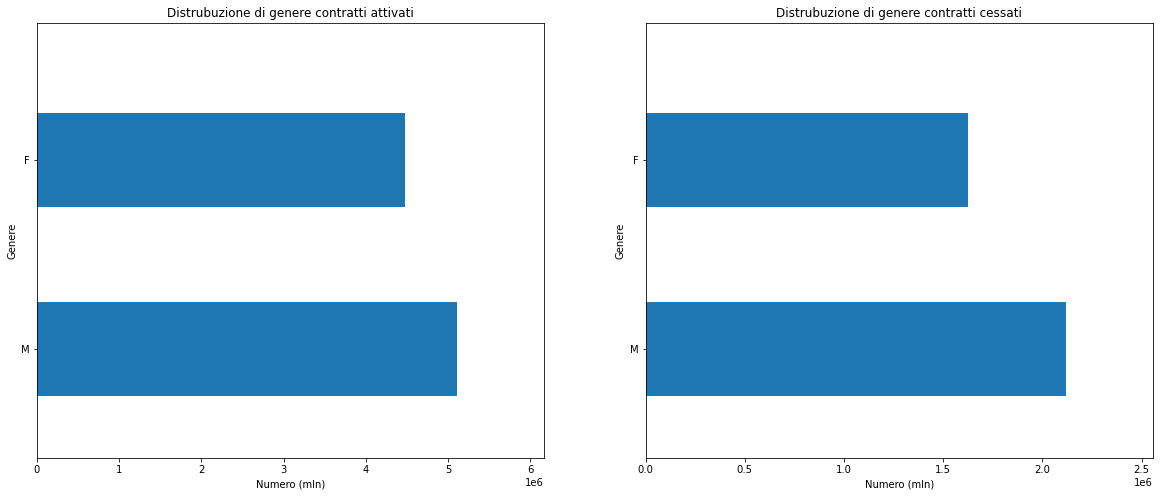

In [ ]:
# Plot della distribuzione del genere suddivisa per Categoria di contratto 
# Attivato - Cessato
Studio_Distrib_Genere()

### 1.2 - Value analysis (nulls and outliers).

- We introduced a graph (for each dataset) to understand how many and which null values are present in the dataset

- Our choice was to not consider rows with null values within them since they represent a small percentage of the total number of records; but before removing them from the dataset, however, it is necessary to understand whether rows with null values are related to a particular class of people (so as to avoid introducing bias within the analyses)

- In order to understand whether eliminating rows with null values might have introduced a "bias" within the dataset, we checked that there were no irregularities in the distribution of null values




DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
ITALIANO                          0
MODALITA                          0
dtype: int64
**********************************
DATA                            0
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    1019
TITOLOSTUDIO                  440
CONTRATTO                       0
MODALITALAVORO                  0
PROVINCIAIMPRESA                0
ITALIANO                        0
MODALITA                        0
dtype: int64


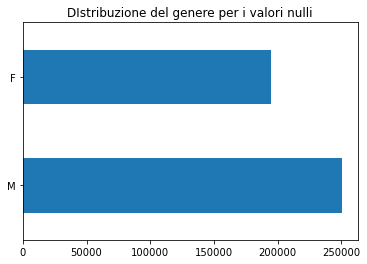

In [ ]:
# Plot del numero dei valori nulli e della distribuzione degli stessi M-F
Studio_Valori_Nulli()

In [ ]:
# Rimozione dei valori poco significativi per lo studio
Remove_Outliers()

Età massima dopo la rimozione dei valori poco significativi: 90


In [ ]:
# Rimozione dei valori nulli 
Remove_Nulls()

### 1.3 - Results analysis values (nulls and outliers).

Eliminating rows with null values (and considering the most relevant items) should not create bias within the dataset because:

- Regarding gender, the distribution is similar to the overall distribution (men are a greater number than women)

- Values that are (in our opinion) insignificant have been removed (age > 90 years)

# 2 - Cleaning and transforming the dataset

We realized that there were inconsistencies within the dataset that needed to be fixed:

- renaming column "Italiani" which actually reflected the "nazionalità" of the subject __-->better understanding of the data__.
- converting date format to DateTime __--> this allows us to take advantage of the operations offered by datetime__
- only the year of the activated contract was of interest to our study. We therefore chose to introduce a new "ANNO" column, "MESE"



In [ ]:
# Divide la data
Split_Date()

In [ ]:
## Rename della colonna ITALIANO
df_globale.rename(columns = {"ITALIANO":"NAZIONALITA"}, inplace = True)

### 2.1 - Data extraction related to the purpose of the analysis.
In this section we are going to extract from the dataset only those individuals who:

- __Are over the age of 40 who have received a contract activation__

- __Are older than 40 years of age who received a contract termination__


After extracting only the records pertaining to our study, we will go back to check the data for bias.

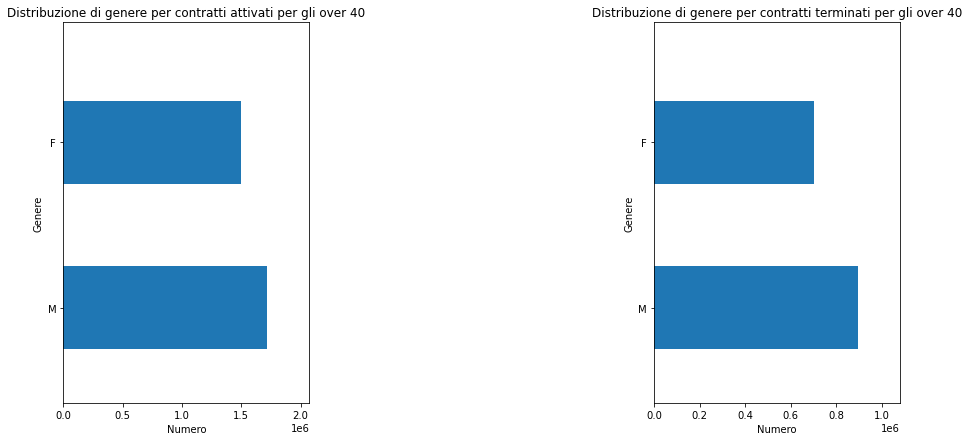

In [ ]:
df_attivati_over_40,df_cessati_over_40 = Extract_Print_Data()

### 2.2 - Results value extraction and distribution.

The data have a distribution similar to that of the initial dataset. This suggests to us that even by reducing the number of records we are considering, the data do not have gender bias

# 3 - Analysis of economic sector

In [ ]:
df_settore_ecnomico = Studio_Settore_Ecnonmico_Dettaglio()
df_settore_ecnomico

,SETTORE,NUMERO_ATTIVATI,NUMERO_TERMINATI
0,Attività di famiglie e convivenze come datori ...,200356,173737
1,Alberghi,174554,23886
2,"Attività di produzione cinematografica, di vid...",171065,3241
3,Pulizia generale (non specializzata) di edifici,110099,81315
4,Istruzione secondaria di primo grado: scuole m...,107325,13192
5,Costruzione di edifici residenziali e non resi...,107128,84066
6,Ristorazione con somministrazione,96255,46997
7,Altri servizi di supporto alle imprese nca,95594,58143
8,Istruzione primaria: scuole elementari,65634,7450
9,Trasporto di merci su strada,60038,46874


# 4 - Join with Ateco Dataset

##### This section will allow a grouping according to ateco section codes regarding the job sector
The idea for this join comes from the fact that having a very populated dataset, we need to group together all those job categories that fall under the same sector. To do precisely that, we decided to merge with the Ateco dataset that already contains the division by sectors.

**This operation will allow us to reduce the number of total classes while still grouping similar activities in the same sector**


In [ ]:
# Importazione e pulizia del nuovo dataset
df_ateco = Import_And_Clean_Ateco()

In [ ]:
# Join con codici Ateco - Attivati -
df_attivati_over_40 = Join_Ateco_DF(df_attivati_over_40)

# Join con codici Ateco - Cessati - 
df_cessati_over_40 = Join_Ateco_DF(df_cessati_over_40)

In [ ]:
df_attivati_over_40.groupby(["HYPER_CATEGORIA_ATECO"]).count()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,MODALITA,ANNO,MESE,Codice_ateco,MACRO_CATEGORIA_ATECO
HYPER_CATEGORIA_ATECO,,,,,,,,,,,,,,
A,85440,85440,85440,85440,85440,85440,85440,85440,85440,85440,85440,85440,85440,85440
B,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205,2205
C,484451,484451,484451,484451,484451,484451,484451,484451,484451,484451,484451,484451,484451,484451
D,2732,2732,2732,2732,2732,2732,2732,2732,2732,2732,2732,2732,2732,2732
E,12142,12142,12142,12142,12142,12142,12142,12142,12142,12142,12142,12142,12142,12142
F,220903,220903,220903,220903,220903,220903,220903,220903,220903,220903,220903,220903,220903,220903
G,220434,220434,220434,220434,220434,220434,220434,220434,220434,220434,220434,220434,220434,220434
H,161552,161552,161552,161552,161552,161552,161552,161552,161552,161552,161552,161552,161552,161552
I,364238,364238,364238,364238,364238,364238,364238,364238,364238,364238,364238,364238,364238,364238


# 5 - Seasonality study

 - We constructed month by month, a dataset that would show us how many contracts are activated and how many are terminated in order to have benchmarks on the various categories
 - We decided to take into account only the years from 2009 to the present  
 - The categories we decided to study are:
     - Scientific and technical professional activities : as it is an area of direct interest since our faculty is positioned in this very category
     - Health care : as the impact of covid may have drastically changed the numbers related to hiring and/or layoffs

In [ ]:
# Raggruppamento contratti attivati
df_grouped_attivati = Group_Activate()

In [ ]:
# Raggruppamento contratti cessati
df_grouped_cessati = Group_DeActivate()

In [ ]:
# Filtraggio per anno superiore a 2009
df_grouped_attivati_filtered = Filter_Dataset(df_grouped_attivati,2009)

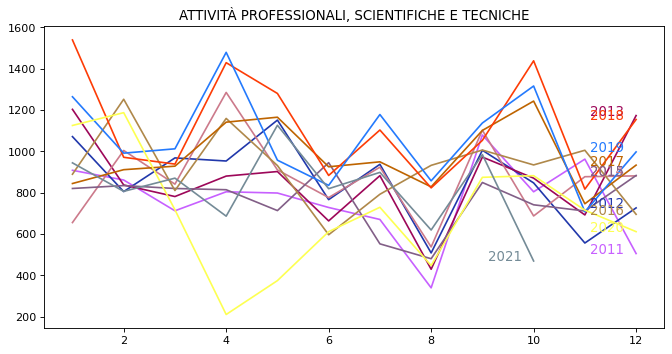

In [ ]:
# Stampa i grafici relativi ai trend per i contratti attivati
# in relazione alla categoria "Attività professionali Scientifihe e tecniche"
Plot_Trend(df_grouped_attivati_filtered,"M")

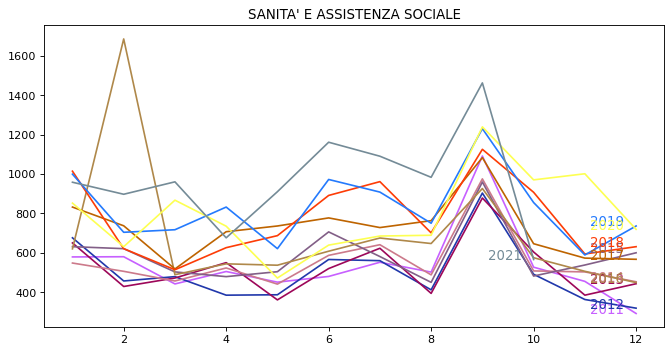

In [ ]:
# Stampa i grafici relativi ai trend per i contratti attivati
# in relazione alla categoria "Sanità"
Plot_Trend(df_grouped_attivati_filtered,"Q")

In [ ]:
# Filtraggio per anno superiore a 2009
df_grouped_cessati_filtered = Filter_Dataset(df_grouped_cessati,2009)

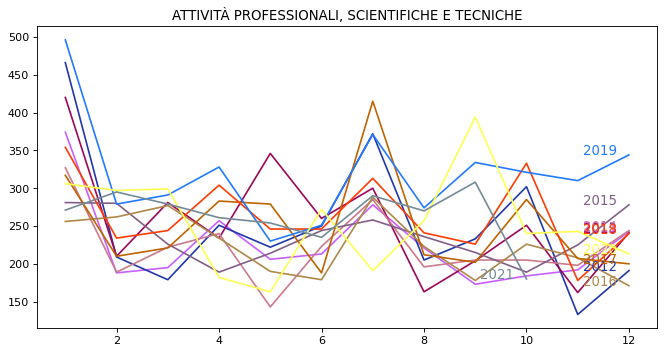

In [ ]:
# Stampa i grafici relativi ai trend per i contratti cessati
# in relazione alla categoria "Attività professionali Scientifihe e tecniche"
Plot_Trend(df_grouped_cessati_filtered,"M")

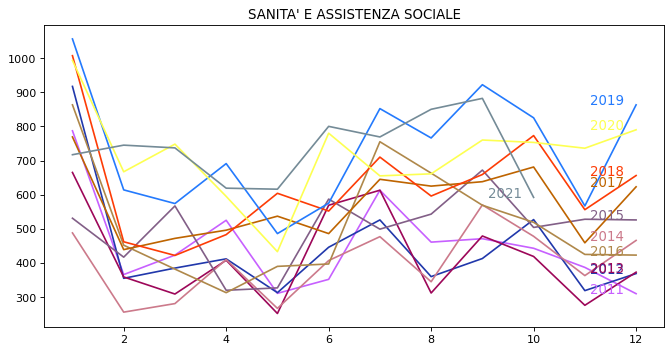

In [ ]:
# Stampa i grafici relativi ai trend per i contratti cessati
# in relazione alla categoria "Sanita"
Plot_Trend(df_grouped_cessati_filtered,"Q")

In [ ]:
# Estrae dal dataset originario, solo le informazioni delle categorie inerenti
# allo studio
new_df = Create_Category_Dataset()
new_df

,HYPER_CATEGORIA_ATECO,ANNO,MESE,VALUE_x,VALUE_y,DATA
1813,M,2009,4,2,3.0,2009-04-01
1814,M,2009,5,4,1.0,2009-05-01
1815,M,2009,6,404,99.0,2009-06-01
1816,M,2009,7,539,277.0,2009-07-01
1817,M,2009,8,258,159.0,2009-08-01
...,...,...,...,...,...,...
2566,Q,2021,6,1161,800.0,2021-06-01
2567,Q,2021,7,1090,769.0,2021-07-01
2568,Q,2021,8,983,850.0,2021-08-01
2569,Q,2021,9,1462,882.0,2021-09-01


## 5.1 - "Scientific and Technical Professional Activities" category study

<module 'matplotlib.pyplot' from '/Users/mac-josh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

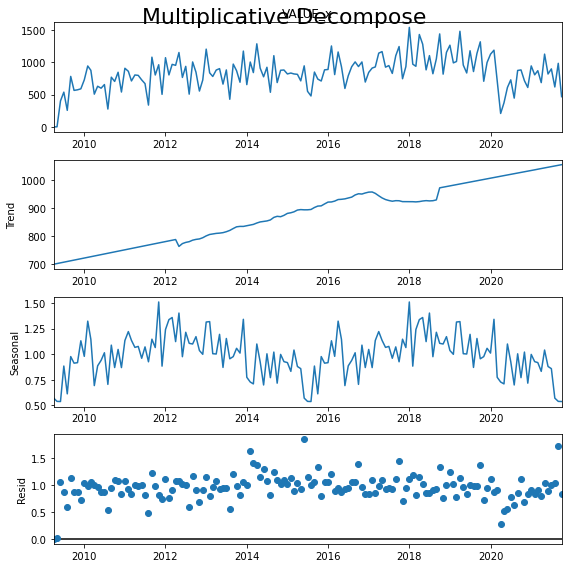

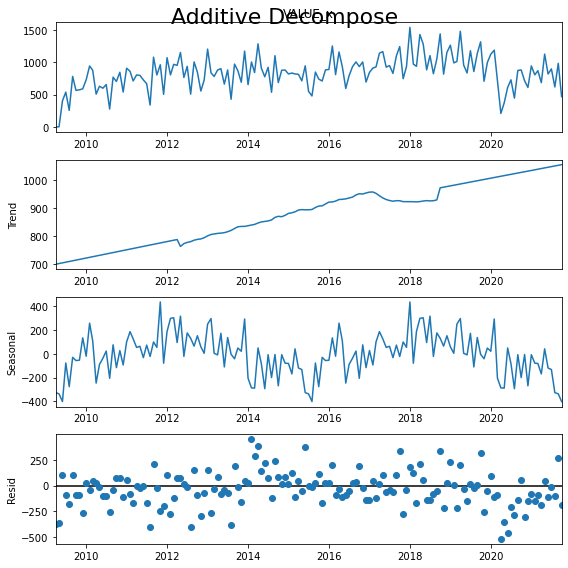

In [ ]:
# Assunzioni
df_Att_Pro_Tec = Prep_Dataset(new_df,"M","VALUE_y")
Studio_Seasonality(df_Att_Pro_Tec,74,"VALUE_x")

In [ ]:
# Calcola ADF
p_value(df_Att_Pro_Tec["VALUE_x"])

ADF Statistic: -1.978478
p-value: 0.296089


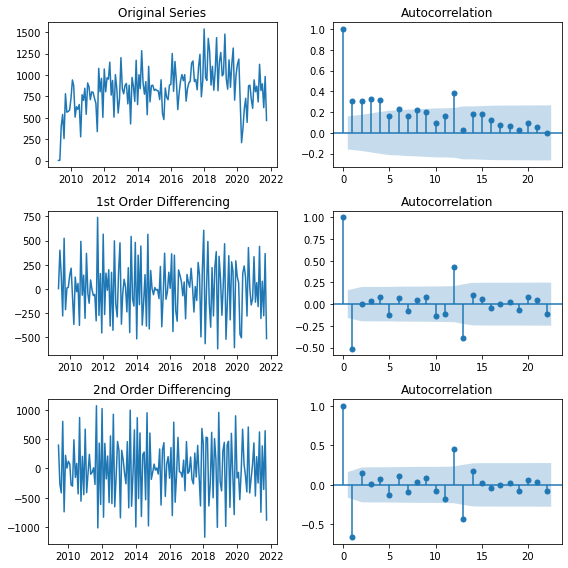

In [ ]:
# Stampa i grafici della differenziazione (1 e 2) e di Correlazione
plot_stationarity(df_Att_Pro_Tec["VALUE_x"])

In [ ]:
# Calcola ADF
p_value(df_Att_Pro_Tec["VALUE_x"].diff())

ADF Statistic: -4.862483
p-value: 0.000041


<module 'matplotlib.pyplot' from '/Users/mac-josh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

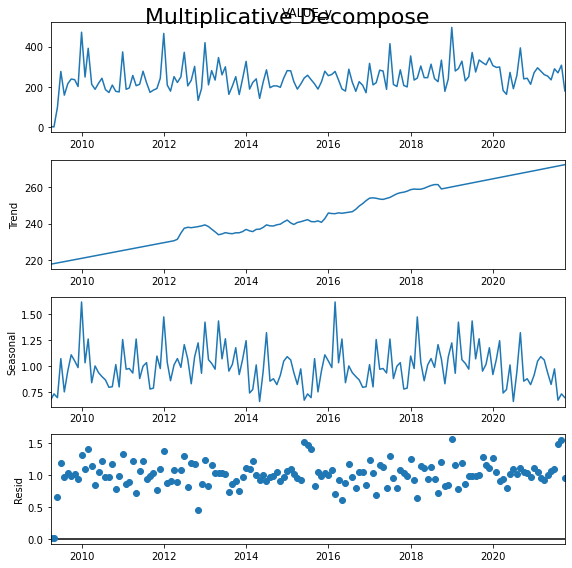

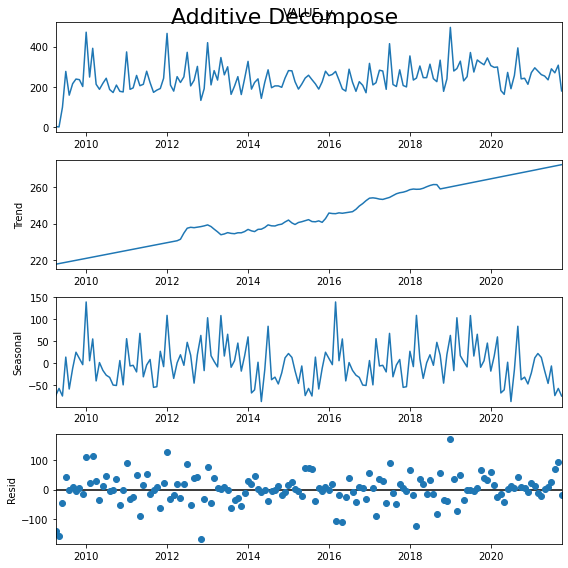

In [ ]:
# Licenziamenti
df_Att_Pro_Tec_1 = Prep_Dataset(new_df,"M","VALUE_x")
Studio_Seasonality(df_Att_Pro_Tec_1,74,"VALUE_y")

In [ ]:
# Calcola ADF
p_value(df_Att_Pro_Tec_1["VALUE_y"])

ADF Statistic: -1.730813
p-value: 0.415311


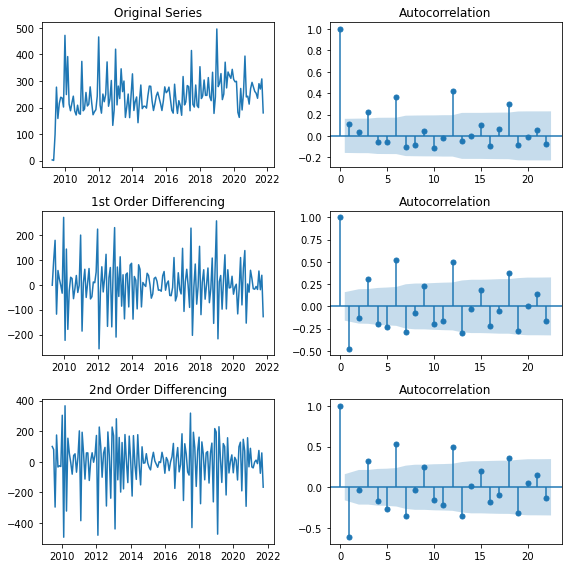

In [ ]:
# Stampa i grafici della differenziazione (1 e 2) e di Correlazione
plot_stationarity(df_Att_Pro_Tec_1["VALUE_y"])

In [ ]:
p_value(df_Att_Pro_Tec_1["VALUE_y"].diff())

ADF Statistic: -9.193930
p-value: 0.000000


# 5.2 - "HealthCare" Category study

<module 'matplotlib.pyplot' from '/Users/mac-josh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

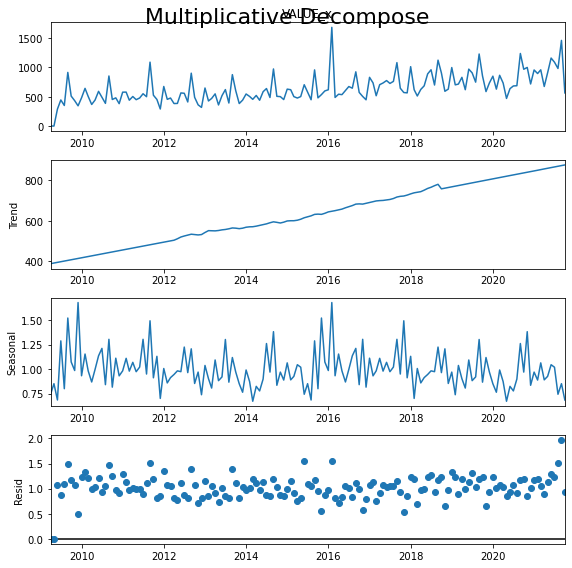

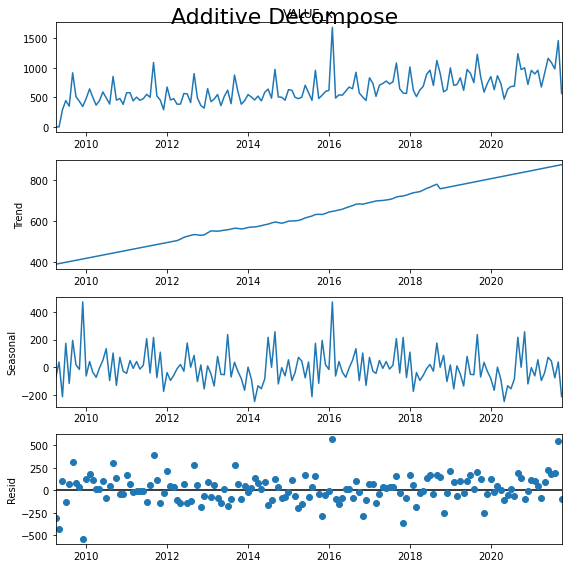

In [ ]:
# Assunzioni 
df_San = Prep_Dataset(new_df,"Q","VALUE_y")
Studio_Seasonality(df_San,74,"VALUE_x")

In [ ]:
# Calcola ADF
p_value(df_San["VALUE_x"])

ADF Statistic: 0.088455
p-value: 0.965264


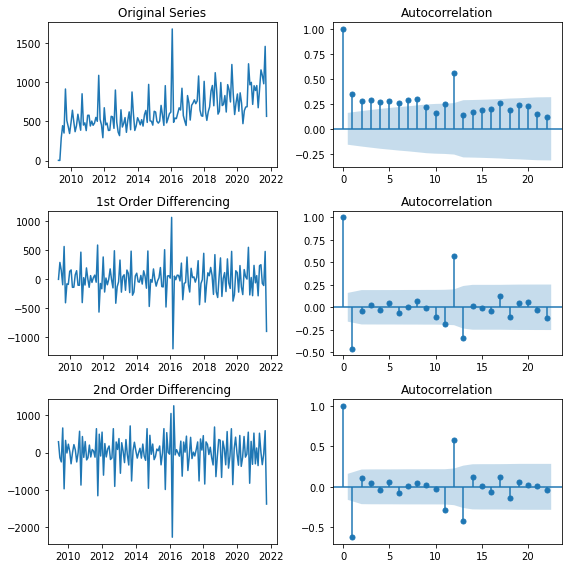

In [ ]:
# Stampa i grafici della differenziazione (1 e 2) e di Correlazione
plot_stationarity(df_San["VALUE_x"])

In [ ]:
# Applica ADF
p_value(df_San["VALUE_x"].diff())

ADF Statistic: -6.351754
p-value: 0.000000


<module 'matplotlib.pyplot' from '/Users/mac-josh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

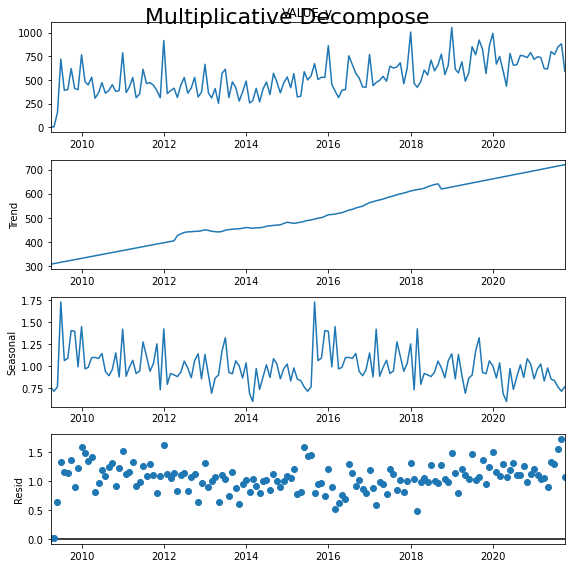

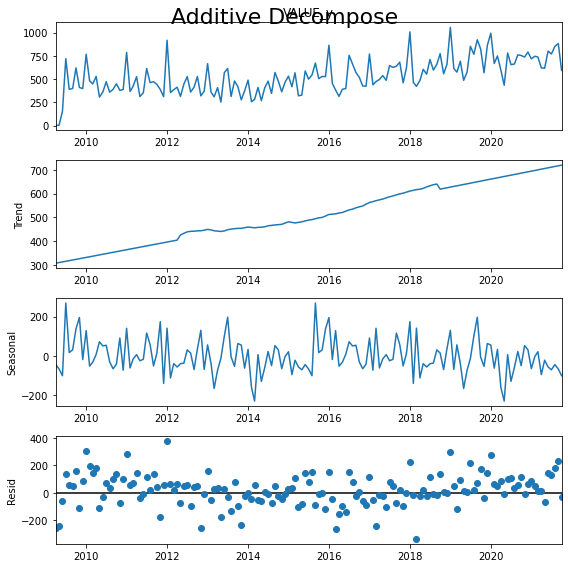

In [ ]:
# Licenziamenti
df_San_1 = Prep_Dataset(new_df,"Q","VALUE_x")
Studio_Seasonality(df_San_1,74,"VALUE_y")

In [ ]:
# Applica ADF
p_value(df_San_1)

ADF Statistic: 0.220492
p-value: 0.973388


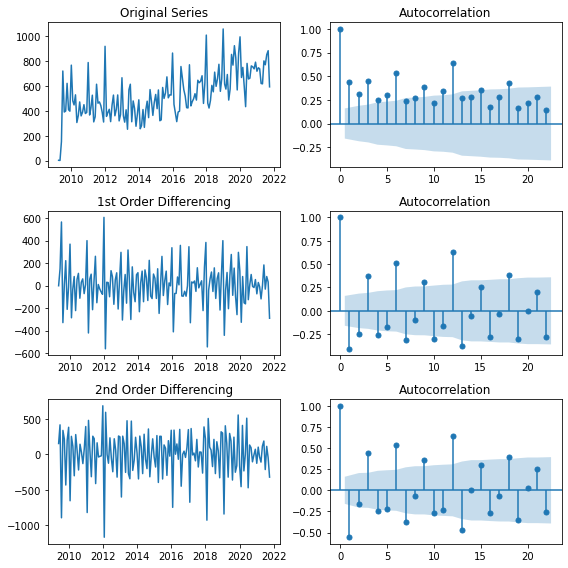

In [ ]:
# Stampa i grafici della differenziazione (1 e 2) e di Correlazione
plot_stationarity(df_San_1["VALUE_y"])

In [ ]:
# Ricalcolo del valore p-value
p_value(df_San_1["VALUE_y"].diff())

ADF Statistic: -7.233275
p-value: 0.000000


# 6 - Time Series Forecasting

##  "Scientific and technical professional activities" Forecasting

### 6.1.1 - Hiring Forecasting Recruitmen

In [ ]:
# Rcava valori ottimai per p e q per le assunzioni
Studio_Arima(df_Att_Pro_Tec,"VALUE_x")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11291D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   7.113D+00
  F =   7.1129075181585453     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84656D+00    |proj g|=  1.90595D-02

At iterate    5    f=  6.84358D+00    |proj g|=  1.89688D-03

At iterate   10    f=  6.84346D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   1.776D-07   6.843D+00
  F =   6.8434623537175394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  6.84360D+00    |proj g|=  6.91980D-04

At iterate   10    f=  6.84340D+00    |proj g|=  1.88232D-03

At iterate   15    f=  6.84339D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   1.776D-07   6.843D+00
  F =   6.8433889967549568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84301D+00    |proj g|=  1.94758D-02


 This problem is unconstrained.



At iterate    5    f=  6.83986D+00    |proj g|=  4.87610D-04

At iterate   10    f=  6.83960D+00    |proj g|=  1.79492D-03

At iterate   15    f=  6.83958D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   7.994D-07   6.840D+00
  F =   6.8395763228855850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83689D+00    |proj g|=  2.04715D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95602D+00    |proj g|=  1.75273D-03

At iterate    5    f=  6.95601D+00    |proj g|=  1.35891D-05

At iterate   10    f=  6.95601D+00    |proj g|=  2.84217D-06

At iterate   15    f=  6.95601D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     27      1     0     0   1.776D-07   6.956D+00
  F =   6.9560101525376314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84654D+00    |proj g|=  1.93087D-02

At iterate    5    f=  6.84350D+00    |proj g|=  2.07656D-04

At iterate   10    f=  6.84345D+00    |proj g|=  2.80931D-04

At iterate   15    f=  6.84344D+00    |proj g|=  5.04485D-05

At iterate   20    f=  6.84344D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   8.882D-08   6.843D+00
  F =   6.8434385150216315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.



At iterate   20    f=  6.83450D+00    |proj g|=  5.74651D-05

At iterate   25    f=  6.83450D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   1.776D-07   6.835D+00
  F =   6.8345002262300856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83367D+00    |proj g|=  1.74215D-02

At iterate    5    f=  6.83012D+00    |proj g|=  5.44009D-04

At iter

 This problem is unconstrained.



At iterate   25    f=  6.82981D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   8.882D-08   6.830D+00
  F =   6.8298082873999846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88215D+00    |proj g|=  1.72102D-03

At iterate    5    f=  6.88215D+00    |proj g|=  1.08091D-04

At iterate   10    f=  6.88214D+00    |proj g|=  1.50537D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  6.88212D+00    |proj g|=  1.77636D-07

At iterate   25    f=  6.88212D+00    |proj g|=  7.10543D-07

At iterate   30    f=  6.88212D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     39      1     0     0   1.776D-07   6.882D+00
  F =   6.8821214782124738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84579D+00    |proj g|=  9.18012D-03

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   2.665D-07   6.843D+00
  F =   6.8431562747231389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84978D+00    |proj g|=  3.60696D-02

At iterate    5    f=  6.84518D+00    |proj g|=  1.69198D-03

At iterate   10    f=  6.84042D+00    |proj g|=  2.57008D-02


 This problem is unconstrained.



At iterate   15    f=  6.83722D+00    |proj g|=  1.12594D-03

At iterate   20    f=  6.83714D+00    |proj g|=  1.99574D-04

At iterate   25    f=  6.83713D+00    |proj g|=  7.50777D-04

At iterate   30    f=  6.83713D+00    |proj g|=  3.28626D-06
  ys=-5.086E-11  -gs= 7.047E-12 BFGS update SKIPPED

At iterate   35    f=  6.83713D+00    |proj g|=  1.68754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     64      1     1     0   1.688D-06   6.837D+00
  F =   6.8371312213927693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate    5    f=  6.79535D+00    |proj g|=  2.17015D-02

At iterate   10    f=  6.79043D+00    |proj g|=  2.84130D-02

At iterate   15    f=  6.78769D+00    |proj g|=  1.43375D-02

At iterate   20    f=  6.78730D+00    |proj g|=  1.05499D-02

At iterate   25    f=  6.78620D+00    |proj g|=  1.78275D-03

At iterate   30    f=  6.78617D+00    |proj g|=  7.90585D-03

At iterate   35    f=  6.78608D+00    |proj g|=  8.83267D-03

At iterate   40    f=  6.78602D+00    |proj g|=  1.38636D-03

At iterate   45    f=  6.78602D+00    |proj g|=  3.78364D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.84187D+00    |proj g|=  2.56852D-03

At iterate   15    f=  6.84121D+00    |proj g|=  4.16307D-03

At iterate   20    f=  6.84113D+00    |proj g|=  1.22569D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   0.000D+00   6.841D+00
  F =   6.8411327541146250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86621D+00    |proj g|=  2.74584D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  6.84304D+00    |proj g|=  1.06706D-03

At iterate   25    f=  6.84304D+00    |proj g|=  2.63700D-04

At iterate   30    f=  6.84303D+00    |proj g|=  5.34506D-04

At iterate   35    f=  6.84303D+00    |proj g|=  4.88320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    137      2     0     0   3.737D-04   6.843D+00
  F =   6.8430334258487848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88188D+00    |proj g|=  5.95328D-02

At iterate    5    f=  6.84894D+00    |proj g|=  8.70832D-03

At iterate   10    f=  6.84394D+00    |proj g|=  6.35962D-03
  ys=-1.886E-03  -gs= 1.032E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  6.84328D+00    |proj g|=  4.43139D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16    109      3     1     0   4.431D-03   6.843D+00
  F =   6.8432817569743065     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84812D+00    |proj g|=  1.25707D-02

At iterate    5    f=  6.84787D+00    |proj g|=  1.83853D-04


 This problem is unconstrained.



At iterate   10    f=  6.84783D+00    |proj g|=  3.91847D-03

At iterate   15    f=  6.84775D+00    |proj g|=  8.97060D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   1.776D-07   6.848D+00
  F =   6.8477483734876810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84621D+00    |proj g|=  4.73606D-02

At iterate    5    f=  6.83719D+00    |proj g|=  3.66294D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92076D+00    |proj g|=  7.52824D-02

At iterate    5    f=  6.86164D+00    |proj g|=  1.40204D-02

At iterate   10    f=  6.85425D+00    |proj g|=  3.92841D-03

At iterate   15    f=  6.85402D+00    |proj g|=  6.41265D-04

At iterate   20    f=  6.85398D+00    |proj g|=  5.72520D-04

At iterate   25    f=  6.85398D+00    |proj g|=  2.37232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     45      1     0     0   

 This problem is unconstrained.



At iterate   25    f=  6.83958D+00    |proj g|=  2.44427D-03

At iterate   30    f=  6.83957D+00    |proj g|=  8.17124D-04

At iterate   35    f=  6.83957D+00    |proj g|=  4.70557D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.83956D+00    |proj g|=  4.11227D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  6.83956D+00    |proj g|=  3.42126D-04

At iterate   50    f=  6.83956D+00    |proj g|=  7.10809D-04

At iterate   55    f=  6.83956D+00    |proj g|=  6.72529D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  6.83956D+00    |proj g|=  1.48237D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   65    f=  6.83956D+00    |proj g|=  2.86349D-04

At iterate   70    f=  6.83956D+00    |proj g|=  4.68692D-04

At iterate   75    f=  6.83956D+00    |proj g|=  5.40901D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     78    295      6     0     0   2.639D-04   6.840D+00
  F =   6.8395618430243577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.80227D+00    |proj g|=  3.98117D-02

At iterate    5    f=  6.79388D+00    |proj g|=  1.56087D-02

At iterate   10    f=  6.78171D+00    |proj g|=  1.36708D-02

At iterate   15    f=  6.77921D+00    |proj g|=  7.55680D-03

At iterate   20    f=  6.77607D+00    |proj g|=  2.45175D-02

At iterate   25    f=  6.77523D+00    |proj g|=  2.30004D-02

At iterate   30    f=  6.77463D+00    |proj g|=  1.07466D-02

At iterate   35    f=  6.77435D+00    |proj g|=  4.13758D-03

At iterate   40    f=  6.77428D+00    |proj g|=  3.66702D-03

At iterate   45    f=  6.77393D+00    |proj g|=  1.79655D-02

At iterate   50    f=  6.77364D+00    |proj g|=  1.10843D-02

At iterate   55    f=  6.77353D+00    |proj g|=  2.05311D-03

At iterate   60    f=  6.77336D+00    |proj g|=  2.44897D-03

At iterate   65    f=  6.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83747D+00    |proj g|=  3.56084D-02

At iterate    5    f=  6.83223D+00    |proj g|=  3.05800D-03

At iterate   10    f=  6.83180D+00    |proj g|=  1.93268D-03

At iterate   15    f=  6.83100D+00    |proj g|=  1.62812D-03

At iterate   20    f=  6.83099D+00    |proj g|=  1.77636D-07

At iterate   25    f=  6.83099D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     38      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94165D+00    |proj g|=  1.02621D-01

At iterate    5    f=  6.84661D+00    |proj g|=  6.05311D-03

At iterate   10    f=  6.83662D+00    |proj g|=  4.34657D-03

At iterate   15    f=  6.83600D+00    |proj g|=  3.95328D-04

At iterate   20    f=  6.83600D+00    |proj g|=  1.23537D-03

At iterate   25    f=  6.83599D+00    |proj g|=  1.27818D-03

At iterate   30    f=  6.83598D+00    |proj g|=  1.00568D-03

At iterate   35    f=  6.83598D+00    |proj g|=  3.44880D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.83598D+00    |proj g|=  1.12399D-03

At iterate   45    f=  6.83598D+00    |proj g|=  8.22009D-04
  ys=-2.318E-14  -gs= 4.865E-14 BFGS update SKIPPED

At iterate   50    f=  6.83598D+00    |proj g|=  1.19149D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  6.83598D+00    |proj g|=  9.81082D-04
  ys=-8.486E-08  -gs= 6.752E-08 BFGS update SKIPPED

At iterate   60    f=  6.83598D+00    |proj g|=  8.92530D-04

At iterate   65    f=  6.83598D+00    |proj g|=  4.48974D-04
  ys=-5.013E-16  -gs= 1.234E-16 BFGS update SKIPPED

At iterate   70    f=  6.83598D+00    |proj g|=  7.90124D-04
  ys=-2.610E-13  -gs= 3.247E-13 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.533E-11  -gs= 4.690E-11 BFGS update SKIPPED

At iterate   75    f=  6.83598D+00    |proj g|=  9.07807D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f=  6.83598D+00    |proj g|=  6.09024D-04

At iterate   85    f=  6.83598D+00    |proj g|=  4.34319D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.233E-11  -gs= 3.249E-11 BFGS update SKIPPED

At iterate   90    f=  6.83598D+00    |proj g|=  8.74500D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.922E-12  -gs= 1.130E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   95    f=  6.83598D+00    |proj g|=  7.80975D-04

At iterate  100    f=  6.83598D+00    |proj g|=  3.92752D-04

At iterate  105    f=  6.83598D+00    |proj g|=  1.23590D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  110    f=  6.83598D+00    |proj g|=  5.97833D-04
  ys=-5.194E-17  -gs= 2.418E-16 BFGS update SKIPPED

At iterate  115    f=  6.83598D+00    |proj g|=  9.05587D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  120    f=  6.83598D+00    |proj g|=  9.78684D-04
  ys=-9.489E-16  -gs= 5.221E-15 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8    121    690     12     9     0   9.787D-04   6.836D+00
  F =   6.8359816324866776     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94216D+00    |proj g|=  9.74631D-02

At iterate    5    f=  6.84693D+00    |proj g|=  1.37778D-02

At iterate   10    f=  6.84135D+00    |proj g|=  5.86624D-03

At iterate   15    f=  6.83955D+00    |proj g|=  8.09752D-03
  ys=-4.784E-04  -gs= 2.241E-04 BFGS update SKIPPED

At iterate   20    f=  6.83946D+00    |proj g|=  2.80762D-03

At iterate   25    f=  6.83942D+00    |proj g|=  2.82707D-03

At iterate   30    f=  6.83940D+00    |proj g|=  4.64917D-03

At iterate   35    f=  6.83940D+00    |proj g|=  6.99902D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36    166      2     1     0   6.999D-03   6.839D+00
  F =   6.8393990265487554     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.85342D+00    |proj g|=  1.81417D-01

At iterate    5    f=  6.82943D+00    |proj g|=  7.06786D-02

At iterate   10    f=  6.82411D+00    |proj g|=  4.32975D-02


 This problem is unconstrained.



At iterate   15    f=  6.80691D+00    |proj g|=  1.34164D-02

At iterate   20    f=  6.80531D+00    |proj g|=  8.21334D-03

At iterate   25    f=  6.80519D+00    |proj g|=  1.20125D-02

At iterate   30    f=  6.80369D+00    |proj g|=  3.44364D-02

At iterate   35    f=  6.80343D+00    |proj g|=  8.50253D-04

At iterate   40    f=  6.80342D+00    |proj g|=  7.24754D-05

At iterate   45    f=  6.80342D+00    |proj g|=  3.27471D-04

At iterate   50    f=  6.80342D+00    |proj g|=  1.66267D-04

At iterate   55    f=  6.80342D+00    |proj g|=  9.01235D-04

At iterate   60    f=  6.80341D+00    |proj g|=  1.40412D-03

At iterate   65    f=  6.80339D+00    |proj g|=  1.95266D-03

At iterate   70    f=  6.80339D+00    |proj g|=  3.99858D-04

At iterate   75    f=  6.80339D+00    |proj g|=  1.26681D-03

At iterate   80    f=  6.80339D+00    |proj g|=  5.97478D-04

At iterate   85    f=  6.80339D+00    |proj g|=  1.76215D-04

At iterate   90    f=  6.80339D+00    |proj g|=  6.78568D-05

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


,p,q,aic,bic,sum_aic_bic
0,0,0,2137.872255,2143.893526,4281.765781
6,1,0,2092.803046,2101.834952,4194.637997
12,2,0,2072.636443,2084.678985,4157.315428
26,4,2,2072.194478,2096.279561,4168.474039
33,5,3,2071.819708,2101.926061,4173.745769
27,4,3,2069.868553,2096.964271,4166.832823
21,3,3,2068.984527,2093.069609,4162.054137
32,5,2,2068.79449,2095.890207,4164.684697
20,3,2,2066.910028,2087.984475,4154.894503
30,5,0,2066.717928,2087.792375,4154.510302


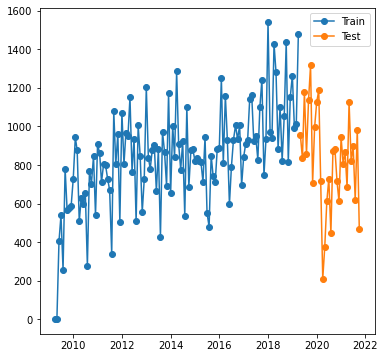

In [ ]:
# Divide il dataset in Train e Test per le assunzioni
train_Att_Assunzioni,test_Att_Assunzioni = Split_df(df_Att_Pro_Tec,"VALUE_x",0.8)

In [ ]:
Build_Model(train_Att_Assunzioni,2,4,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1473.621, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1485.908, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1477.186, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1475.333, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1493.152, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1473.202, Time=0.33 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1475.256, Time=0.24 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1474.736, Time=0.88 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=1475.044, Time=1.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1474.146, Time=0.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1477.246, Time=0.40 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=1475.407, Time=1.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1474.717, Time=0.46 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1474.823, Time=0.39 sec
 ARIMA(1,0,1)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  121
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                -732.601
Date:                    Thu, 19 May 2022   AIC                           1473.202
Time:                            11:45:00   BIC                           1483.967
Sample:                                 0   HQIC                          1477.568
                                    - 121                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.9576     13.835      2.888      0.004      12.841      67.075
ar.S.L12       0.2890      0.202      1.433      0.152      -0.106       0.684
ma.S.L12      -0.7651      0.180     -4.253      0.000      -1.118      -0.413
sigma2      3.839e+04   5582.798      6.877      0.000    2.74e+04    4.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.61   Prob(JB):                         0.42
Heteroskedasticity (H):               0.82   Skew:                             0.26
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

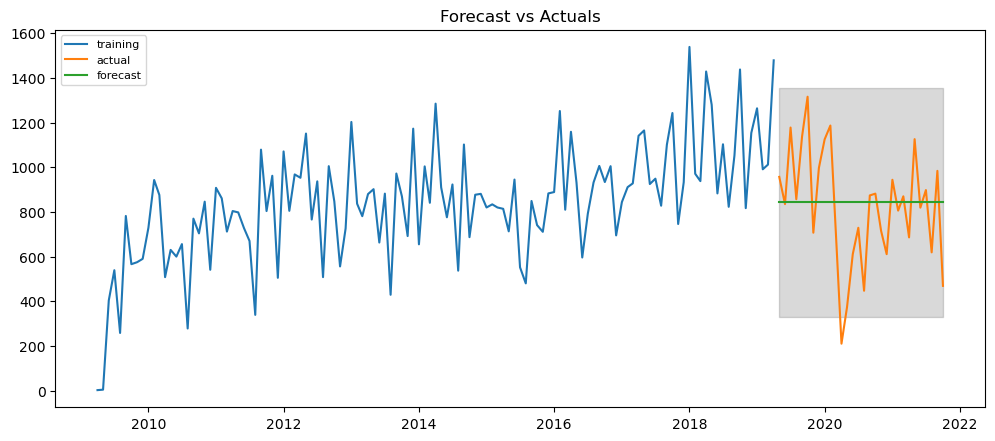

In [ ]:
# Predizione dei valori relativi alle assunzioni durante questo biennio
pred_Att_Ass_Arima = Predict(train_Att_Assunzioni,test_Att_Assunzioni,0,0,0,30)

In [ ]:
# Printa le metriche di valutazione per il modello Arima
Evaluation_Metrics(test_Att_Assunzioni,pred_Att_Ass_Arima)

RMSE: 254.289191


The prediction is not accurate. As we can see a kind of average (the straight line) is performed. Probably the model can't do any better, let's try implementing SARIMAX now (since the previous study also provided in possible values to be used with SARIMAX).

One thing to note is that by splitting the data (training and testing) in this way, the forecasts we are going to make, not take into account the data in the covid period, and this is a point in favor of our research since we can analyze how the market would have evolved if COVID had not been a determining factor.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19958D+00    |proj g|=  2.82367D-01

At iterate    5    f=  6.13622D+00    |proj g|=  5.30906D-03

At iterate   10    f=  6.13591D+00    |proj g|=  5.83028D-04



 This problem is unconstrained.


At iterate   15    f=  6.13327D+00    |proj g|=  4.48164D-03

At iterate   20    f=  6.13226D+00    |proj g|=  3.76118D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     29      1     0     0   3.398D-06   6.132D+00
  F =   6.1322569408057852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


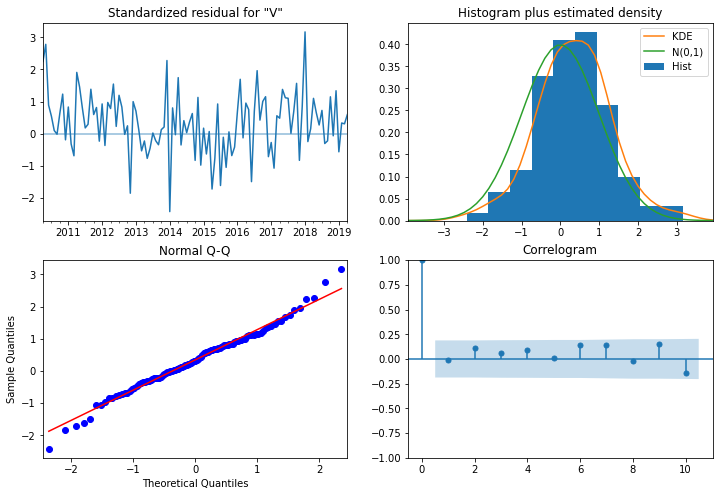

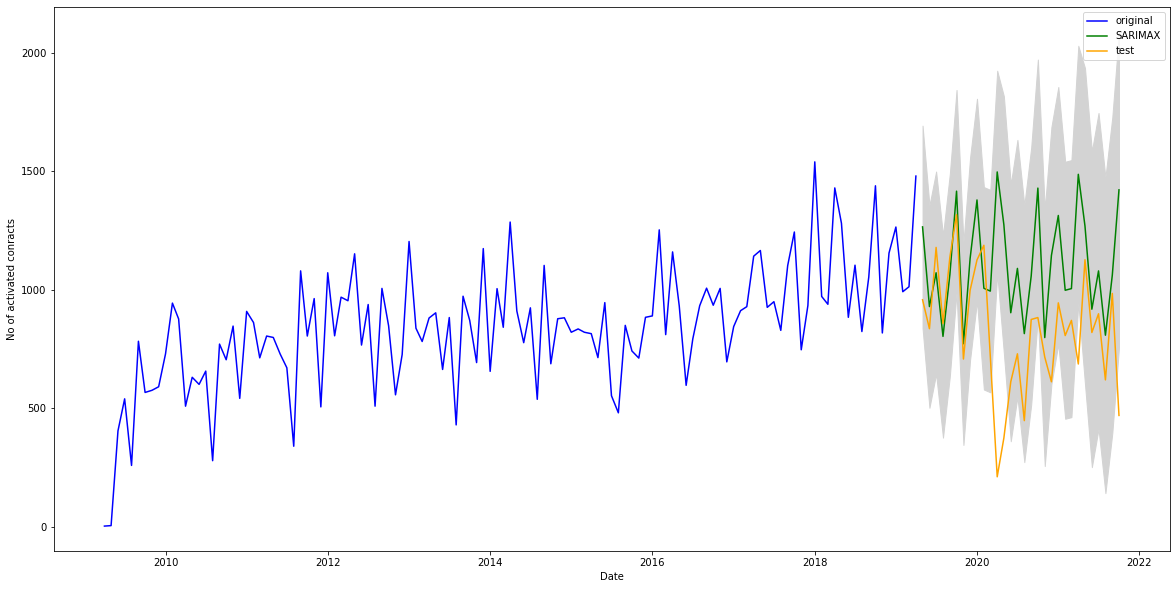

In [ ]:
# Implementazione di Sarimax
pred_Att_Ass_Sarima = Go_Sarimax(train_Att_Assunzioni,test_Att_Assunzioni,"VALUE_x",30,0,0,0,1,1,1,12)

In [ ]:
#Printa le metriche di valutazione per il modello Sarima
Evaluation_Metrics(test_Att_Assunzioni,pred_Att_Ass_Sarima.predicted_mean)

RMSE: 432.321374


### 6.1.2 - Layoffs Forecasting

In [ ]:
# Rcava valori ottimai per p e q per i licenziamenti
Studio_Arima(df_Att_Pro_Tec_1,"VALUE_y")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95483D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   5.955D+00
  F =   5.9548278081222872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.67059D+00    |proj g|=  1.02243D-02

At iterate   15    f=  5.66835D+00    |proj g|=  7.85416D-04

At iterate   20    f=  5.66831D+00    |proj g|=  1.29674D-05

At iterate   25    f=  5.66831D+00    |proj g|=  1.76659D-04

At iterate   30    f=  5.66831D+00    |proj g|=  2.93099D-06

At iterate   35    f=  5.66831D+00    |proj g|=  2.93099D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     49      1     0     0   4.441D-07   5.668D+00
  F =   5.6683094687002242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate    5    f=  5.67905D+00    |proj g|=  1.45648D-02

At iterate   10    f=  5.66989D+00    |proj g|=  1.06507D-02

At iterate   15    f=  5.66762D+00    |proj g|=  4.49951D-04

At iterate   20    f=  5.66756D+00    |proj g|=  1.63691D-04

At iterate   25    f=  5.66756D+00    |proj g|=  1.04805D-05

At iterate   30    f=  5.66756D+00    |proj g|=  4.18332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     50      1     0     0   5.329D-07   5.668D+00
  F =   5.6675573510764901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68544D+00    |proj g|=  3.25290D-02

At iterate    5    f=  5.65799D+00    |proj g|=  2.82847D-02

At iterate   10    f=  5.65377D+00    |proj g|=  5.69012D-03

At iterate   15    f=  5.65312D+00    |proj g|=  1.41487D-04

At iterate   20    f=  5.65310D+00    |proj g|=  1.83764D-04

At iterate   25    f=  5.65310D+00    |proj g|=  4.08562D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     46      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  5.64215D+00    |proj g|=  2.64402D-03

At iterate   20    f=  5.64206D+00    |proj g|=  1.06013D-03

At iterate   25    f=  5.64206D+00    |proj g|=  2.27196D-04

At iterate   30    f=  5.64206D+00    |proj g|=  9.85878D-06

At iterate   35    f=  5.64206D+00    |proj g|=  1.77636D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     64      1     0     0   6.217D-06   5.642D+00
  F =   5.6420563868601565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.66840D+00    |proj g|=  1.14753D-04

At iterate   20    f=  5.66838D+00    |proj g|=  2.72671D-04

At iterate   25    f=  5.66838D+00    |proj g|=  1.91847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     43      1     0     0   7.994D-07   5.668D+00
  F =   5.6683808358667331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69628D+00    |proj g|=  3.21034D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  5.67056D+00    |proj g|=  4.98250D-03

At iterate   15    f=  5.66515D+00    |proj g|=  5.22036D-03

At iterate   20    f=  5.66509D+00    |proj g|=  2.84039D-04

At iterate   25    f=  5.66509D+00    |proj g|=  3.22409D-05

At iterate   30    f=  5.66508D+00    |proj g|=  6.75016D-06

At iterate   35    f=  5.66508D+00    |proj g|=  1.89182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     51      1     0     0   5.151D-06   5.665D+00
  F =   5.6650847810742491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  5.66438D+00    |proj g|=  1.58540D-04

At iterate   25    f=  5.66437D+00    |proj g|=  1.91847D-04

At iterate   30    f=  5.66437D+00    |proj g|=  2.30038D-05

At iterate   35    f=  5.66437D+00    |proj g|=  2.26485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     60      1     0     0   2.256D-05   5.664D+00
  F =   5.6643680348748262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.66307D+00    |proj g|=  1.54710D-02

At iterate   10    f=  5.65618D+00    |proj g|=  1.35619D-02

At iterate   15    f=  5.65174D+00    |proj g|=  2.05116D-03

At iterate   20    f=  5.65169D+00    |proj g|=  1.02300D-03

At iterate   25    f=  5.65167D+00    |proj g|=  2.36966D-04

At iterate   30    f=  5.65167D+00    |proj g|=  8.32223D-05

At iterate   35    f=  5.65167D+00    |proj g|=  3.28626D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     52      1     0     0   3.286D-06   5.652D+00
  F =   5.6516673199785066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68440D+00    |proj g|=  3.90235D-02

At iterate    5    f=  5.67001D+00    |proj g|=  1.16032D-02

At iterate   10    f=  5.66848D+00    |proj g|=  1.24523D-03

At iterate   15    f=  5.66835D+00    |proj g|=  1.01785D-04

At iterate   20    f=  5.66834D+00    |proj g|=  1.27898D-05

At iterate   25    f=  5.66834D+00    |proj g|=  9.01501D-05

At iterate   30    f=  5.66834D+00    |proj g|=  8.88178D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67736D+00    |proj g|=  6.75950D-02

At iterate    5    f=  5.66635D+00    |proj g|=  1.97664D-03



 This problem is unconstrained.


At iterate   10    f=  5.66624D+00    |proj g|=  3.84670D-04

At iterate   15    f=  5.66623D+00    |proj g|=  2.22045D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     34      1     0     0   1.155D-06   5.666D+00
  F =   5.6662348477309799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60487D+00    |proj g|=  6.20106D-02

At iterate    5    f=  5.60157D+00    |proj g|=  1.34757D-02

At itera

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     54      1     0     0   1.865D-06   5.599D+00
  F =   5.5987648990396846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59598D+00    |proj g|=  6.25871D-02

At iterate    5    f=  5.58961D+00    |proj g|=  3.79386D-02


 This problem is unconstrained.



At iterate   10    f=  5.58259D+00    |proj g|=  3.07752D-02

At iterate   15    f=  5.58075D+00    |proj g|=  2.52165D-02

At iterate   20    f=  5.58046D+00    |proj g|=  4.53184D-03

At iterate   25    f=  5.57947D+00    |proj g|=  7.26433D-02

At iterate   30    f=  5.57810D+00    |proj g|=  5.81251D-03

At iterate   35    f=  5.57681D+00    |proj g|=  3.45638D-02

At iterate   40    f=  5.57543D+00    |proj g|=  7.96110D-03

At iterate   45    f=  5.57532D+00    |proj g|=  1.10507D-03

At iterate   50    f=  5.57523D+00    |proj g|=  4.23110D-03

At iterate   55    f=  5.57520D+00    |proj g|=  6.90292D-04

At iterate   60    f=  5.57518D+00    |proj g|=  2.69997D-03

At iterate   65    f=  5.57518D+00    |proj g|=  4.49951D-04

At iterate   70    f=  5.57518D+00    |proj g|=  6.41887D-04

At iterate   75    f=  5.57517D+00    |proj g|=  3.31379D-04

At iterate   80    f=  5.57517D+00    |proj g|=  7.87903D-04

At iterate   85    f=  5.57517D+00    |proj g|=  4.13358D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58512D+00    |proj g|=  3.66936D-02

At iterate    5    f=  5.57154D+00    |proj g|=  4.39385D-02

At iterate   10    f=  5.56341D+00    |proj g|=  1.65304D-02

At iterate   15    f=  5.56178D+00    |proj g|=  4.75266D-02

At iterate   20    f=  5.55998D+00    |proj g|=  3.06511D-02

At iterate   25    f=  5.55741D+00    |proj g|=  1.22269D-02

At iterate   30    f=  5.55675D+00    |proj g|=  3.72982D-03

At iterate   35    f=  5.55635D+00    |proj g|=  2.12950D-03

At iterate   40    f=  5.55622D+00    |proj g|=  4.61897D-03

At iterate   45    f=  5.55617D+00    |proj g|=  4.37890D-03

At iterate   50    f=  5.55616D+00    |proj g|=  1.09930D-03

At iterate   55    f=  5.55615D+00    |proj g|=  2.33387D-03

At iterate   60    f=  5.55615D+00    |proj g|=  1.26583D-03

At iterate   65    f=  5.5

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  5.69821D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   7.994D-07   5.698D+00
  F =   5.6982121485116899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67985D+00    |proj g|=  8.29113D-02

At iterate    5    f=  5.65305D+00    |proj g|=  7.38716D-03

At iterate   10    f=  5.64490D+00    |proj g|=  4.02158D-03

At itera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66544D+00    |proj g|=  7.79690D-02

At iterate    5    f=  5.64145D+00    |proj g|=  9.81952D-03

At iterate   10    f=  5.64097D+00    |proj g|=  3.85469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   1.776D-07   5.641D+00
  F =   5.6409734605623427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     33      1     0     0   1.155D-06   5.567D+00
  F =   5.5668972045585230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72760D+00    |proj g|=  2.13070D+00

At iterate    5    f=  5.60777D+00    |proj g|=  7.28258D-02

At iterate   10    f=  5.58925D+00    |proj g|=  4.58328D-01

At iterate   15    f=  5.58614D+00    |proj g|=  6.46022D-02

At iterate   20    f=  5.58167D+00    |proj g|=  2.49153D-01

At iterate   25    f=  5.57855D+00    |proj g|=  9.22453D-03

At iterate   30    f=  5.57831D+00    |proj g|=  2.76788D-02

At iterate   35    f=  5.57823D+00    |proj g|=  1.85732D-02

At iterate   40    f=  5.57693D+00    |proj g|=  1.61709D-01

At iterate   45    f=  5.57634D+00    |proj g|=  8.74261D-03

At iterate   50    f=  5.57633D+00    |proj g|=  2.92566D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  5.57633D+00    |proj g|=  3.76588D-05

At iterate   60    f=  5.57633D+00    |proj g|=  3.88134D-05

At iterate   65    f=  5.57633D+00    |proj g|=  2.93987D-05

At iterate   70    f=  5.57633D+00    |proj g|=  5.12479D-05

At iterate   75    f=  5.57633D+00    |proj g|=  1.11022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     78    162      3     0     0   3.322D-05   5.576D+00
  F =   5.5763348991917665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72573D+00    |proj g|=  2.13711D+00

At iterate    5    f=  5.60684D+00    |proj g|=  1.20705D-01

At iterate   10    f=  5.59120D+00    |proj g|=  4.13564D-01

At iterate   15    f=  5.58293D+00    |proj g|=  3.62529D-02


 This problem is unconstrained.



At iterate   20    f=  5.57720D+00    |proj g|=  1.10369D-02

At iterate   25    f=  5.57686D+00    |proj g|=  8.38432D-03

At iterate   30    f=  5.57682D+00    |proj g|=  2.52438D-03

At iterate   35    f=  5.57681D+00    |proj g|=  8.37552D-03

At iterate   40    f=  5.57650D+00    |proj g|=  2.43273D-02

At iterate   45    f=  5.57636D+00    |proj g|=  6.39346D-03

At iterate   50    f=  5.57634D+00    |proj g|=  1.10402D-02

At iterate   55    f=  5.57634D+00    |proj g|=  1.18021D-03

At iterate   60    f=  5.57634D+00    |proj g|=  1.02407D-04

At iterate   65    f=  5.57634D+00    |proj g|=  1.94866D-04

At iterate   70    f=  5.57634D+00    |proj g|=  1.25677D-04

At iterate   75    f=  5.57634D+00    |proj g|=  7.99361D-05

At iterate   80    f=  5.57634D+00    |proj g|=  9.63674D-05

At iterate   85    f=  5.57634D+00    |proj g|=  3.05533D-05

At iterate   90    f=  5.57634D+00    |proj g|=  1.51879D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65288D+00    |proj g|=  6.58231D-02

At iterate    5    f=  5.63558D+00    |proj g|=  6.23501D-05

At iterate   10    f=  5.63558D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     15      1     0     0   8.882D-08   5.636D+00
  F =   5.6355777965560465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   20    f=  5.64454D+00    |proj g|=  1.67697D-03

At iterate   25    f=  5.64453D+00    |proj g|=  2.36371D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  5.64452D+00    |proj g|=  5.86695D-03
  ys=-3.381E-13  -gs= 4.619E-13 BFGS update SKIPPED

At iterate   35    f=  5.64451D+00    |proj g|=  2.21148D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37    225      5     1     0   2.997D-03   5.645D+00
  F =   5.6445145965424999     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75480D+00    |proj g|=  2.46418D+00

At iterate    5    f=  5.60193D+00    |proj g|=  3.74968D-02

At iterate   10    f=  5.59180D+00    |proj g|=  3.64595D-01

At iterate   15    f=  5.58364D+00    |proj g|=  1.17959D-01

At iterate   20    f=  5.57957D+00    |proj g|=  1.92747D-02

At iterate   25    f=  5.57700D+00    |proj g|=  6.19292D-02


 This problem is unconstrained.



At iterate   30    f=  5.57648D+00    |proj g|=  1.36509D-02

At iterate   35    f=  5.57644D+00    |proj g|=  5.90461D-04

At iterate   40    f=  5.57644D+00    |proj g|=  2.47802D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     66      1     0     0   2.931D-05   5.576D+00
  F =   5.5764448044594177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54127D+00    |proj g|=  5.59457D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  5.52387D+00    |proj g|=  4.01785D-03

At iterate   30    f=  5.52377D+00    |proj g|=  3.99716D-03

At iterate   35    f=  5.52376D+00    |proj g|=  3.02514D-04

At iterate   40    f=  5.52376D+00    |proj g|=  4.52971D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     55      1     0     0   4.263D-06   5.524D+00
  F =   5.5237638117833772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  5.57753D+00    |proj g|=  6.64532D-02

At iterate   25    f=  5.57604D+00    |proj g|=  7.54636D-02

At iterate   30    f=  5.57492D+00    |proj g|=  8.22986D-03

At iterate   35    f=  5.57472D+00    |proj g|=  2.62744D-02

At iterate   40    f=  5.56622D+00    |proj g|=  5.15757D-01

At iterate   45    f=  5.55727D+00    |proj g|=  5.08371D-02

At iterate   50    f=  5.55184D+00    |proj g|=  4.40696D-02

At iterate   55    f=  5.55175D+00    |proj g|=  3.05045D-02

At iterate   60    f=  5.55028D+00    |proj g|=  1.47678D-01

At iterate   65    f=  5.54837D+00    |proj g|=  1.54749D-01

At iterate   70    f=  5.54701D+00    |proj g|=  1.30962D-01

At iterate   75    f=  5.54668D+00    |proj g|=  5.20435D-02
  ys=-2.091E-06  -gs= 2.239E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   80    f=  5.54656D+00    |proj g|=  5.61009D-03

At iterate   85    f=  5.54654D+00    |proj g|=  2.44595D-02

At iterate   90    f=  5.54653D+00    |proj g|=  2.17852D-03

At iterate   95    f=  5.54653D+00    |proj g|=  2.70431D-02
  ys=-5.874E-06  -gs= 3.526E-06 BFGS update SKIPPED

At iterate  100    f=  5.54650D+00    |proj g|=  6.35287D-03
  ys=-4.795E-07  -gs= 1.999E-06 BFGS update SKIPPED

At iterate  105    f=  5.54649D+00    |proj g|=  4.90452D-03

At iterate  110    f=  5.54647D+00    |proj g|=  4.39406D-02

At iterate  115    f=  5.54645D+00    |proj g|=  2.81979D-03

At iterate  120    f=  5.54645D+00    |proj g|=  8.30171D-03

At iterate  125    f=  5.54645D+00    |proj g|=  1.30175D-02

At iterate  130    f=  5.54644D+00    |proj g|=  6.47979D-03

At iterate  135    f=  5.54644D+00    |proj g|=  1.41184D-02

At iterate  140    f=  5.54644D+00    |proj g|=  3.50147D-03

At iterate  145    f=  5.54644D+00    |proj g|=  5.70788D-03

At iterate  150    f=  5.54


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  175    f=  5.54643D+00    |proj g|=  2.37961D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  180    f=  5.54643D+00    |proj g|=  7.93792D-03

At iterate  185    f=  5.54643D+00    |proj g|=  1.92566D-03

At iterate  190    f=  5.54643D+00    |proj g|=  4.22764D-03

At iterate  195    f=  5.54643D+00    |proj g|=  3.47695D-03
  ys=-2.602E-08  -gs= 1.889E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  200    f=  5.54643D+00    |proj g|=  5.42117D-03

At iterate  205    f=  5.54643D+00    |proj g|=  5.59544D-03

At iterate  210    f=  5.54643D+00    |proj g|=  7.77334D-03

At iterate  215    f=  5.54643D+00    |proj g|=  4.18536D-03

At iterate  220    f=  5.54643D+00    |proj g|=  9.46070D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  225    f=  5.54643D+00    |proj g|=  3.70077D-03

At iterate  230    f=  5.54643D+00    |proj g|=  3.65601D-03

At iterate  235    f=  5.54643D+00    |proj g|=  4.97646D-03

At iterate  240    f=  5.54642D+00    |proj g|=  1.87925D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  245    f=  5.54641D+00    |proj g|=  5.72244D-03

At iterate  250    f=  5.54641D+00    |proj g|=  4.07869D-03

At iterate  255    f=  5.54640D+00    |proj g|=  6.68621D-03

At iterate  260    f=  5.54640D+00    |proj g|=  4.60663D-03

At iterate  265    f=  5.54640D+00    |proj g|=  6.36104D-03

At iterate  270    f=  5.54640D+00    |proj g|=  5.71321D-03

At iterate  275    f=  5.54640D+00    |proj g|=  1.05281D-02

At iterate  280    f=  5.54640D+00    |proj g|=  8.83720D-03

At iterate  285    f=  5.54640D+00    |proj g|=  3.84688D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  290    f=  5.54640D+00    |proj g|=  2.41895D-03

At iterate  295    f=  5.54639D+00    |proj g|=  9.36247D-03

At iterate  300    f=  5.54639D+00    |proj g|=  4.01039D-03

At iterate  305    f=  5.54638D+00    |proj g|=  1.27707D-02

At iterate  310    f=  5.54637D+00    |proj g|=  5.04885D-03

At iterate  315    f=  5.54637D+00    |proj g|=  4.59810D-03

At iterate  320    f=  5.54637D+00    |proj g|=  5.89990D-03

At iterate  325    f=  5.54636D+00    |proj g|=  2.23013D-03

At iterate  330    f=  5.54636D+00    |proj g|=  1.35756D-02

At iterate  335    f=  5.54635D+00    |proj g|=  4.59561D-03

At iterate  340    f=  5.54635D+00    |proj g|=  6.94351D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  345    f=  5.54635D+00    |proj g|=  6.55227D-03

At iterate  350    f=  5.54635D+00    |proj g|=  3.60378D-03
  ys=-9.125E-08  -gs= 1.156E-06 BFGS update SKIPPED

At iterate  355    f=  5.54635D+00    |proj g|=  1.06933D-02

At iterate  360    f=  5.54635D+00    |proj g|=  3.32250D-03

At iterate  365    f=  5.54635D+00    |proj g|=  6.29825D-03

At iterate  370    f=  5.54635D+00    |proj g|=  8.74270D-03

At iterate  375    f=  5.54635D+00    |proj g|=  5.22640D-03
  ys=-2.079E-10  -gs= 1.118E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.620E-07  -gs= 1.344E-07 BFGS update SKIPPED

At iterate  380    f=  5.54635D+00    |proj g|=  7.08402D-03

At iterate  385    f=  5.54635D+00    |proj g|=  2.51452D-03

At iterate  390    f=  5.54635D+00    |proj g|=  6.32276D-03

At iterate  395    f=  5.54634D+00    |proj g|=  3.78453D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  400    f=  5.54634D+00    |proj g|=  2.99254D-03

At iterate  405    f=  5.54634D+00    |proj g|=  5.34239D-03
  ys=-4.786E-10  -gs= 2.888E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  410    f=  5.54634D+00    |proj g|=  2.74030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10    413   1256     12     8     0   4.498D-03   5.546D+00
  F =   5.5463403377036196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57734D+00    |proj g|=  2.38575D-02

At iterate    5    f=  5.57460D+00    |proj g|=  2.25775D-03

At iterate   10    f=  5.57448D+00    |proj g|=  2.38618D-03

At iterate   15    f=  5.57437D+00    |proj g|=  4.36717D-04

At iterate   20    f=  5.57437D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     26      1     0     0   1.776D-07   5.574D+00
  F =   5.5743717346325505     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57161D+00    |proj g|=  2.46430D-02

At iterate    5    f=  5.56891D+00    |proj g|=  2.75948D-03

At iterate   10    f=  5.56877D+00    |proj g|=  4.24309D-03

At iterate   15    f=  5.56869D+00    |proj g|=  7.98472D-05

At iterate   20    f=  5.56869D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     24      1     0     0   2.665D-07   5.569D+00
  F =   5.5686874479024668     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57121D+00    |proj g|=  2.52123D-02

At iterate    5    f=  5.56746D+00    |proj g|=  3.04157D-03

At iterate   10    f=  5.56718D+00    |proj g|=  8.91198D-04

At iterate   15    f=  5.56705D+00    |proj g|=  4.14362D-03

At iterate   20    f=  5.56702D+00    |proj g|=  7.32481D-04

At iterate   25    f=  5.56702D+00    |proj g|=  3.37508D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     35      1     0     0   

 This problem is unconstrained.



At iterate   25    f=  5.57982D+00    |proj g|=  1.89390D-01

At iterate   30    f=  5.57672D+00    |proj g|=  2.53000D-02

At iterate   35    f=  5.57627D+00    |proj g|=  2.71907D-03

At iterate   40    f=  5.57627D+00    |proj g|=  5.11502D-04

At iterate   45    f=  5.57627D+00    |proj g|=  3.21254D-04

At iterate   50    f=  5.57627D+00    |proj g|=  2.41140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     74      1     0     0   2.411D-04   5.576D+00
  F =   5.5762707150703354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate   20    f=  5.57055D+00    |proj g|=  2.55803D-02

At iterate   25    f=  5.57010D+00    |proj g|=  1.29991D-02

At iterate   30    f=  5.56947D+00    |proj g|=  1.44349D-02

At iterate   35    f=  5.56806D+00    |proj g|=  3.84690D-02

At iterate   40    f=  5.56707D+00    |proj g|=  4.31584D-03

At iterate   45    f=  5.56703D+00    |proj g|=  4.20126D-03

At iterate   50    f=  5.56699D+00    |proj g|=  9.85709D-03

At iterate   55    f=  5.56696D+00    |proj g|=  7.61329D-03

At iterate   60    f=  5.56696D+00    |proj g|=  3.20988D-03

At iterate   65    f=  5.56694D+00    |proj g|=  3.38272D-03

At iterate   70    f=  5.56692D+00    |proj g|=  2.57456D-03

At iterate   75    f=  5.56689D+00    |proj g|=  5.56009D-03

At iterate   80    f=  5.56689D+00    |proj g|=  2.32401D-03

At iterate   85    f=  5.56686D+00    |proj g|=  9.98597D-03

At iterate   90    f=  5.56685D+00    |proj g|=  3.05045D-03

At iterate   95    f=  5.56684D+00    |proj g|=  4.38609D-03

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10    129    278      2     0     0   5.945D-04   5.567D+00
  F =   5.5668010545622151     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62611D+00    |proj g|=  1.13181D-01

At iterate    5    f=  5.57960D+00    |proj g|=  2.37508D-02

At iterate   10    f=  5.57388D+00    |proj g|=  2.18111D-02

At iterate   15    f=  5.57267D+00    |proj g|=  3.70433D-03

At iterate   20    f=  5.57137D+00    |proj g|=  5.69556D-02

At iterate   25    f=  5.56940D+00    |proj g|=  6.45226D-03

At iterate   30    f=  5.56732D+00    |proj g|=  2.15369D-02

At iterate   35    f=  5.56689D+00    |proj g|=  4.27880D-03

At iterate   40    f=  5.56681D+00    |proj g|=  2.81206D-03

At iterate   45    f=  5.56662D+00    |proj g|=  4.01439D-03

At iterate   50    f=  5.56653D+00    |proj g|=  6.23377D-03

At iterate   55    f=  5.56652D+00    |proj g|=  3.15827D-03

At iterate   60    f=  5.56652D+00    |proj g|=  5.22107D-03

At iterate   65    f=  5.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   70    f=  5.56651D+00    |proj g|=  7.50244D-03

At iterate   75    f=  5.56647D+00    |proj g|=  3.51790D-03

At iterate   80    f=  5.56647D+00    |proj g|=  3.66684D-03

At iterate   85    f=  5.56647D+00    |proj g|=  2.41025D-03

At iterate   90    f=  5.56646D+00    |proj g|=  4.75060D-03

At iterate   95    f=  5.56645D+00    |proj g|=  4.72653D-03

At iterate  100    f=  5.56645D+00    |proj g|=  5.73621D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  105    f=  5.56644D+00    |proj g|=  3.08269D-03

At iterate  110    f=  5.56635D+00    |proj g|=  6.54126D-03
  ys=-2.980E-11  -gs= 2.003E-11 BFGS update SKIPPED

At iterate  115    f=  5.56631D+00    |proj g|=  1.68939D-02

At iterate  120    f=  5.56624D+00    |proj g|=  1.00048D-02

At iterate  125    f=  5.56624D+00    |proj g|=  3.46860D-03

At iterate  130    f=  5.56622D+00    |proj g|=  1.19303D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  135    f=  5.56616D+00    |proj g|=  5.03348D-03

At iterate  140    f=  5.56616D+00    |proj g|=  4.34497D-03

At iterate  145    f=  5.56615D+00    |proj g|=  1.84723D-03

At iterate  150    f=  5.56615D+00    |proj g|=  5.45040D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  155    f=  5.56613D+00    |proj g|=  4.18003D-03

At iterate  160    f=  5.56609D+00    |proj g|=  1.45751D-02

At iterate  165    f=  5.56604D+00    |proj g|=  1.08229D-02

At iterate  170    f=  5.56600D+00    |proj g|=  6.75477D-03

At iterate  175    f=  5.56597D+00    |proj g|=  5.59002D-03

At iterate  180    f=  5.56595D+00    |proj g|=  5.91482D-03

At iterate  185    f=  5.56592D+00    |proj g|=  4.97629D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  190    f=  5.56591D+00    |proj g|=  1.68325D-02
  ys=-4.768E-13  -gs= 8.466E-13 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  195    f=  5.56583D+00    |proj g|=  1.34856D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  200    f=  5.56577D+00    |proj g|=  1.32833D-02

At iterate  205    f=  5.56539D+00    |proj g|=  2.32029D-02

At iterate  210    f=  5.56513D+00    |proj g|=  2.00435D-03

At iterate  215    f=  5.56513D+00    |proj g|=  1.19623D-02

At iterate  220    f=  5.56513D+00    |proj g|=  1.03254D-02
  ys=-6.622E-11  -gs= 2.856E-10 BFGS update SKIPPED

At iterate  225    f=  5.56513D+00    |proj g|=  1.05610D-02

At iterate  230    f=  5.56512D+00    |proj g|=  1.19873D-02

At iterate  235    f=  5.56512D+00    |proj g|=  1.06085D-02

At iterate  240    f=  5.56510D+00    |proj g|=  1.59875D-02

At iterate  245    f=  5.56509D+00    |proj g|=  1.33971D-02

At iterate  250    f=  5.56507D+00    |proj g|=  4.53584D-03

At iterate  255    f=  5.56503D+00    |proj g|=  9.87059D-03

At iterate  260    f=  5.56502D+00    |proj g|=  6.14602D-03

At iterate  265    f=  5.56502D+00    |proj g|=  4.53033D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  270    f=  5.56501D+00    |proj g|=  1.48935D-02

At iterate  275    f=  5.56500D+00    |proj g|=  2.17888D-03

At iterate  280    f=  5.56490D+00    |proj g|=  1.01306D-02

At iterate  285    f=  5.56487D+00    |proj g|=  1.06813D-02

At iterate  290    f=  5.56475D+00    |proj g|=  8.25198D-03

At iterate  295    f=  5.56469D+00    |proj g|=  7.82823D-03

At iterate  300    f=  5.56415D+00    |proj g|=  1.97534D-02

At iterate  305    f=  5.56392D+00    |proj g|=  3.28897D-02

At iterate  310    f=  5.56349D+00    |proj g|=  8.77538D-03

At iterate  315    f=  5.56320D+00    |proj g|=  9.69509D-03

At iterate  320    f=  5.56315D+00    |proj g|=  2.11738D-02

At iterate  325    f=  5.56313D+00    |proj g|=  4.26787D-03

At iterate  330    f=  5.56311D+00    |proj g|=  1.66094D-02

At iterate  335    f=  5.56300D+00    |proj g|=  2.64054D-02

At iterate  340    f=  5.56274D+00    |proj g|=  2.64412D-02

At iterate  345    f=  5.56254D+00    |proj g|=  8.46185D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  420    f=  5.55816D+00    |proj g|=  1.23708D-02

At iterate  425    f=  5.55816D+00    |proj g|=  1.77870D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    427   1286     10     5     0   2.149D-02   5.558D+00
  F =   5.5581609646466141     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


,p,q,aic,bic,sum_aic_bic
0,0,0,1790.448342,1796.469613,3586.917955
6,1,0,1753.551418,1762.583324,3516.134742
24,4,0,1720.280958,1738.34477,3458.625728
18,3,0,1719.463645,1734.516821,3453.980466
12,2,0,1717.654985,1729.697526,3447.352511
14,2,2,1711.870454,1729.934266,3441.80472
9,1,3,1711.31041,1729.374222,3440.684633
13,2,1,1710.503367,1725.556543,3436.05991
3,0,3,1710.267205,1725.320382,3435.587587
8,1,2,1709.525434,1724.578611,3434.104045


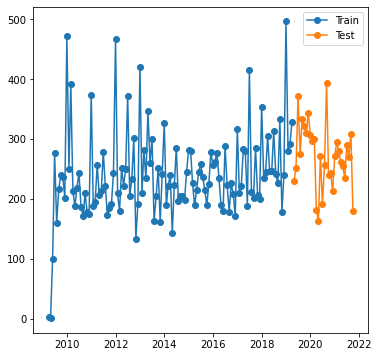

In [ ]:
# Divide il dataset in Train e Test per i licenziamenti
train_Att_Licenziamenti,test_Att_Licenziamenti = Split_df(df_Att_Pro_Tec_1,"VALUE_y",0.8)

In [ ]:
# Costruisce il modello con i parametri precedenti
Build_Model(train_Att_Licenziamenti,4,4,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1211.688, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1218.854, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1212.855, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1209.163, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1218.562, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1217.184, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1206.395, Time=0.65 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1209.542, Time=0.44 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1204.937, Time=0.70 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1208.112, Time=0.20 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  121
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -597.468
Date:                                 Thu, 19 May 2022   AIC                           1204.937
Time:                                         11:46:02   BIC                           1218.393
Sample:                                              0   HQIC                          1210.394
                                                 - 121                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6878      2.499      1.876      0.061      -0.210       9.586
ar.L1          0.2611      0.084      3.119      0.002       0.097       0.425
ma.S.L12      -0.5690      0.135     -4.211      0.000      -0.834      -0.304
ma.S.L24      -0.2759      0.145     -1.905      0.057      -0.560       0.008
sigma2      3013.3889    499.506      6.033      0.000    2034.375    3992.403
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 3.45
Prob(Q):                              0.32   Prob(JB):                         0.18
Heteroskedasticity (H):               0.53   Skew:                             0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

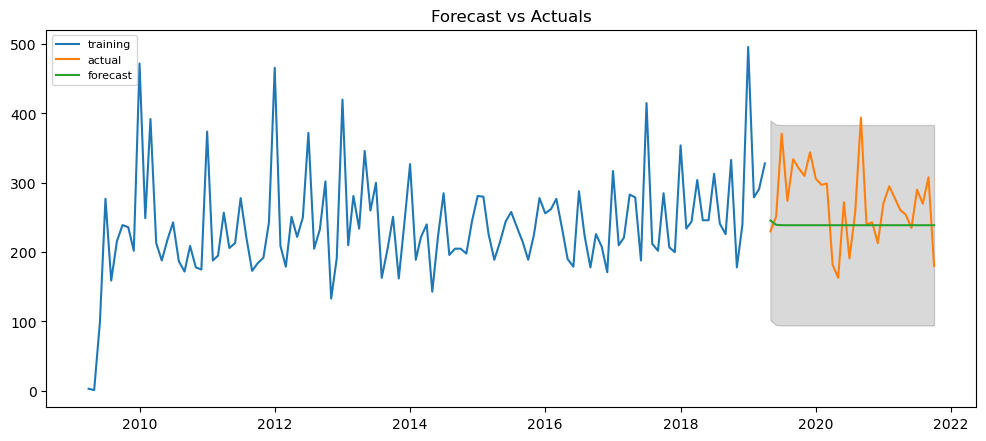

In [ ]:
 # Predizione dei valori relativi alle assunzioni durante questo biennio
pred_Att_Lic_Arima = Predict(train_Att_Licenziamenti,test_Att_Licenziamenti,1,0,0,30)

In [ ]:
# Printa le metriche di valutazione per il modello Arima
Evaluation_Metrics(test_Att_Licenziamenti,pred_Att_Lic_Arima)

RMSE: 62.804033


The prediction is not accurate. As we can see a kind of average (the straight line) is performed. Probably the model cannot do better, let us try to implement SARIMAX now (since the previous study also provided in possible values to be used with SARIMAX).

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05443D+00    |proj g|=  3.58741D-01

At iterate    5    f=  4.95619D+00    |proj g|=  5.48666D-03

At iterate   10    f=  4.95570D+00    |proj g|=  3.42322D-03

At iterate   15    f=  4.95447D+00    |proj g|=  3.53075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.052D-06   4.954D+00
  F =   4.9544513166648558     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


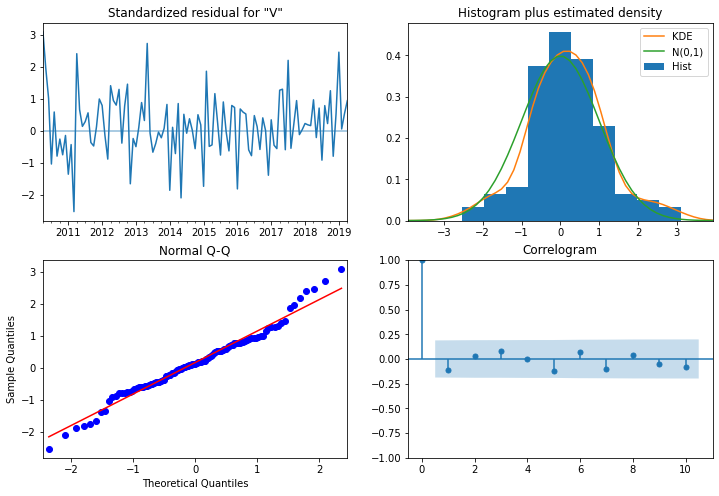

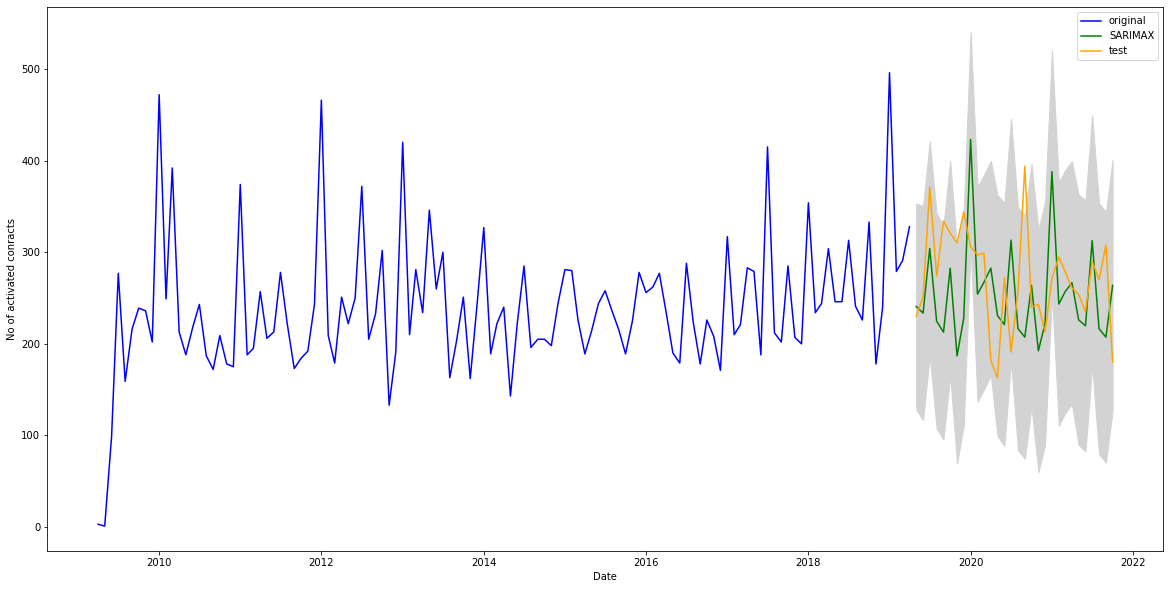

In [ ]:
pred_Att_Lic_Sarima = Go_Sarimax(train_Att_Licenziamenti,test_Att_Licenziamenti,"VALUE_y",30,1,0,0,0,1,2,12)

In [ ]:
# Printa le metriche di valutazione per il modello sarima
Evaluation_Metrics(test_Att_Licenziamenti,pred_Att_Lic_Sarima.predicted_mean)

RMSE: 77.263873


We see that layoffs, in general, have not been so much impacted by the covid.

Possible operation of the layoff freeze law? Maybe.

#  7 - Healthcare Forecasting 

### 7.1 - Hiring Forecasting 

In [ ]:
# Ricava valori ottimai per p e q per i licenziamenti
Studio_Arima(df_San,"VALUE_x")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03982D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   7.040D+00
  F =   7.0398210054518069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75146D+00    |proj g|=  3.65859D-02

At iterate    5    f=  6.73043D+00    |proj g|=  1.89361D-02

At iterate   10    f=  6.71853D+00    |proj g|=  4.19753D-03

At iterate   15    f=  6.71640D+00    |proj g|=  6.57163D-04

At iterate   20    f=  6.71635D+00    |proj g|=  4.38760D-05

At iterate   25    f=  6.71635D+00    |proj g|=  1.08802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     29      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75052D+00    |proj g|=  3.73968D-02

At iterate    5    f=  6.72909D+00    |proj g|=  1.80516D-02

At iterate   10    f=  6.71593D+00    |proj g|=  6.95790D-03

At iterate   15    f=  6.71486D+00    |proj g|=  5.12301D-04

At iterate   20    f=  6.71481D+00    |proj g|=  1.55431D-05

At iterate   25    f=  6.71481D+00    |proj g|=  1.87406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.72927D+00    |proj g|=  1.73582D-02

At iterate   10    f=  6.71782D+00    |proj g|=  7.39746D-03

At iterate   15    f=  6.71466D+00    |proj g|=  1.86970D-03

At iterate   20    f=  6.71452D+00    |proj g|=  1.77902D-04

At iterate   25    f=  6.71451D+00    |proj g|=  1.87406D-05

At iterate   30    f=  6.71451D+00    |proj g|=  1.72307D-05

At iterate   35    f=  6.71451D+00    |proj g|=  3.09086D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     56      1     0     0   5.418D-06   6.715D+00
  F =   6.7145115016081842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  6.71382D+00    |proj g|=  8.87734D-04

At iterate   20    f=  6.71371D+00    |proj g|=  1.86251D-04

At iterate   25    f=  6.71370D+00    |proj g|=  5.24025D-05

At iterate   30    f=  6.71370D+00    |proj g|=  4.46754D-05

At iterate   35    f=  6.71370D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   1.066D-06   6.714D+00
  F =   6.7137031841017016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.72094D+00    |proj g|=  6.03766D-03

At iterate   10    f=  6.71650D+00    |proj g|=  4.81037D-04

At iterate   15    f=  6.71636D+00    |proj g|=  1.24167D-04

At iterate   20    f=  6.71635D+00    |proj g|=  2.21156D-05

At iterate   25    f=  6.71635D+00    |proj g|=  1.97176D-05

At iterate   30    f=  6.71635D+00    |proj g|=  2.12275D-05

At iterate   35    f=  6.71635D+00    |proj g|=  1.70530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     61      1     0     0   1.705D-05   6.716D+00
  F =   6.7163488981512822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75133D+00    |proj g|=  2.94782D-02

At iterate    5    f=  6.73126D+00    |proj g|=  1.03413D-02

At iterate   10    f=  6.71856D+00    |proj g|=  3.66915D-03

At iterate   15    f=  6.70856D+00    |proj g|=  7.99485D-03

At iterate   20    f=  6.70393D+00    |proj g|=  8.84537D-04

At iterate   25    f=  6.70378D+00    |proj g|=  2.56417D-04

At iterate   30    f=  6.70378D+00    |proj g|=  7.72715D-06
  ys=-2.262E-07  -gs= 8.541E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   35    f=  6.70378D+00    |proj g|=  2.20268D-05

At iterate   40    f=  6.70378D+00    |proj g|=  1.38556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     89      2     1     0   0.000D+00   6.704D+00
  F =   6.7037759139576281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75095D+00    |proj g|=  3.27153D-02

At iterate    5    f=  6.73062D+00    |proj g|=  9.53255D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  6.70316D+00    |proj g|=  2.81730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     96      2     0     0   2.817D-04   6.703D+00
  F =   6.7031628406709807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75079D+00    |proj g|=  3.16810D-02




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  6.72980D+00    |proj g|=  9.11591D-03

At iterate   10    f=  6.71655D+00    |proj g|=  4.48042D-03

At iterate   15    f=  6.70352D+00    |proj g|=  9.68026D-03

At iterate   20    f=  6.69794D+00    |proj g|=  1.05844D-03

At iterate   25    f=  6.69768D+00    |proj g|=  2.38920D-04

At iterate   30    f=  6.69767D+00    |proj g|=  2.25242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     57      1     0     0   1.137D-05   6.698D+00
  F =   6.6976711304334744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75019D+00    |proj g|=  3.42698D-02

At iterate    5    f=  6.72874D+00    |proj g|=  8.19389D-03

At iterate   10    f=  6.71830D+00    |proj g|=  7.22880D-03

At iterate   15    f=  6.71486D+00    |proj g|=  5.21423D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  6.70479D+00    |proj g|=  5.09592D-03

At iterate   25    f=  6.69957D+00    |proj g|=  4.17462D-03

At iterate   30    f=  6.69699D+00    |proj g|=  4.07319D-04

At iterate   35    f=  6.69695D+00    |proj g|=  1.98330D-04

At iterate   40    f=  6.69695D+00    |proj g|=  8.62421D-05

At iterate   45    f=  6.69695D+00    |proj g|=  2.78977D-04

At iterate   50    f=  6.69695D+00    |proj g|=  7.01661D-06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  6.69695D+00    |proj g|=  1.33227D-06

At iterate   60    f=  6.69695D+00    |proj g|=  1.42109D-06

At iterate   65    f=  6.69695D+00    |proj g|=  1.59872D-06

At iterate   70    f=  6.69695D+00    |proj g|=  1.42109D-06

At iterate   75    f=  6.69695D+00    |proj g|=  1.90070D-05

At iterate   80    f=  6.69695D+00    |proj g|=  1.11910D-05

At iterate   85    f=  6.69695D+00    |proj g|=  3.87246D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     85    167      3     0     0   3.872D-05   6.697D+00
  F =   6.6969466421001247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84823D+00    |proj g|=  1.54756D-03

At iterate    5    f=  6.84822D+00    |proj g|=  1.11555D-04

At iterate   10    f=  6.84821D+00    |proj g|=  1.01812D-03

At iterate   15    f=  6.84821D+00    |proj g|=  7.99361D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   1.776D-07   6.848D+00
  F =   6.8482090488311131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71668D+00    |proj g|=  2.20831D-02

At iterate    5    f=  6.71429D+00    |proj g|=  5.36371D-04

At iterate   10    f=  6.71405D+00    |proj g|=  6.90816D-03

At iterate   15    f=  6.71390D+00    |proj g|=  1.95399D-06

At iterate   20    f=  6.71390D+00    |proj g|=  5.32907D-07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     61      2     0     0   7.994D-07   6.714D+00
  F =   6.7138958043269517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71759D+00    |proj g|=  4.50966D-02

At iterate    5    f=  6.71343D+00    |proj g|=  5.16263D-03

At iterate   10    f=  6.70890D+00    |proj g|=  3.78854D-02

At iterate   15    f=  6.69017D+00    |proj g|=  2.59234D-02

At iterate   20    f=  6.67095D+00    |proj g|=  1.64494D-01

At iterate   25    f=  6.66977D+00    |proj g|=  1.74333D-02
  ys=-2.294E-03  -gs= 5.684E-04 BFGS update SKIPPED
  ys=-3.380E-08  -gs= 4.115E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  6.66872D+00    |proj g|=  4.78288D-02

At iterate   35    f=  6.66868D+00    |proj g|=  8.98304D-03

At iterate   40    f=  6.66868D+00    |proj g|=  2.14912D-02

At iterate   45    f=  6.66867D+00    |proj g|=  4.40596D-02

At iterate   50    f=  6.66859D+00    |proj g|=  2.71012D-02

At iterate   55    f=  6.66859D+00    |proj g|=  1.51045D-02
  ys=-2.885E-12  -gs= 6.246E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  6.66859D+00    |proj g|=  7.40448D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   65    f=  6.66859D+00    |proj g|=  1.98471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     65    262      4     3     0   1.985D-02   6.669D+00
  F =   6.6685867340139975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71773D+00    |proj g|=  4.61410D-02

At iterate    5    f=  6.71341D+00    |proj g|=  6.21894D-03

At iterate   10    f=  6.70985D+00    |proj g|=  2.63542D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  6.68712D+00    |proj g|=  1.47957D-02

At iterate   30    f=  6.68693D+00    |proj g|=  7.11076D-04

At iterate   35    f=  6.68693D+00    |proj g|=  7.63833D-06

At iterate   40    f=  6.68693D+00    |proj g|=  1.68754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     57      1     0     0   1.776D-06   6.687D+00
  F =   6.6869267343316210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70900D+00    |proj g|=  6.33722D-02

At iterate    5    f=  6.70264D+00    |proj g|=  4.79583D-02

At iterate   10    f=  6.69515D+00    |proj g|=  8.73843D-03

At iterate   15    f=  6.69029D+00    |proj g|=  4.64840D-02

At iterate   20    f=  6.68640D+00    |proj g|=  4.04157D-03

At iterate   25    f=  6.68571D+00    |proj g|=  1.25915D-02

At iterate   30    f=  6.68510D+00    |proj g|=  2.01927D-03

At iterate   35    f=  6.68507D+00    |proj g|=  7.01652D-03

At iterate   40    f=  6.68499D+00    |proj g|=  8.34737D-03

At iterate   45    f=  6.68457D+00    |proj g|=  6.59570D-03

At iterate   50    f=  6.68427D+00    |proj g|=  9.48166D-03

At iterate   55    f=  6.68410D+00    |proj g|=  1.38312D-02

At iterate   60    f=  6.68394D+00    |proj g|=  6.26503D-03

At iterate   65    f=  6.6

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   8.882D-08   6.819D+00
  F =   6.8187503933521967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71623D+00    |proj g|=  2.02343D-02

At iterate    5    f=  6.71468D+00    |proj g|=  5.75540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  6.71527D+00    |proj g|=  1.08500D-03

At iterate   25    f=  6.71525D+00    |proj g|=  9.00879D-04

At iterate   30    f=  6.71525D+00    |proj g|=  2.88836D-04

At iterate   35    f=  6.71525D+00    |proj g|=  5.21716D-04
  ys=-1.496E-08  -gs= 9.866E-09 BFGS update SKIPPED

At iterate   40    f=  6.71525D+00    |proj g|=  1.19726D-04

At iterate   45    f=  6.71525D+00    |proj g|=  6.48370D-04
  ys=-8.655E-09  -gs= 5.479E-09 BFGS update SKIPPED

At iterate   50    f=  6.71525D+00    |proj g|=  2.86526D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  6.71525D+00    |proj g|=  1.37668D-04
  ys=-9.113E-11  -gs= 1.509E-11 BFGS update SKIPPED

At iterate   60    f=  6.71525D+00    |proj g|=  3.97105D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     61    272      3     3     0   3.971D-04   6.715D+00
  F =   6.7152501539732548     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71486D+00    |proj g|=  1.28611D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     60      2     0     0   8.428D+01   6.715D+00
  F =   6.7148555822466101     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72097D+00    |proj g|=  2.53587D-02

At iterate    5    f=  6.70801D+00    |proj g|=  6.48751D-02

At iterate   10    f=  6.69618D+00    |proj g|=  6.36161D-02

At iterate   15    f=  6.69204D+00    |proj g|=  5.75820D-02


 This problem is unconstrained.



At iterate   20    f=  6.69103D+00    |proj g|=  3.69100D-03

At iterate   25    f=  6.69005D+00    |proj g|=  1.41914D-02

At iterate   30    f=  6.68973D+00    |proj g|=  1.76664D-02

At iterate   35    f=  6.68965D+00    |proj g|=  1.25365D-02

At iterate   40    f=  6.68953D+00    |proj g|=  1.97764D-02

At iterate   45    f=  6.68935D+00    |proj g|=  3.30765D-02

At iterate   50    f=  6.68920D+00    |proj g|=  2.55227D-03

At iterate   55    f=  6.68911D+00    |proj g|=  3.74198D-03

At iterate   60    f=  6.68907D+00    |proj g|=  4.42348D-03
  ys=-4.193E-05  -gs= 1.846E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   65    f=  6.68907D+00    |proj g|=  1.53646D-03

At iterate   70    f=  6.68907D+00    |proj g|=  5.26157D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   75    f=  6.68907D+00    |proj g|=  3.23919D-04

At iterate   80    f=  6.68907D+00    |proj g|=  4.98908D-03

At iterate   85    f=  6.68906D+00    |proj g|=  1.88374D-03

At iterate   90    f=  6.68906D+00    |proj g|=  6.48370D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   95    f=  6.68906D+00    |proj g|=  1.29319D-04

At iterate  100    f=  6.68906D+00    |proj g|=  4.44889D-04

At iterate  105    f=  6.68906D+00    |proj g|=  6.11422D-04

At iterate  110    f=  6.68906D+00    |proj g|=  7.59481D-04

At iterate  115    f=  6.68906D+00    |proj g|=  5.85931D-04
  ys=-4.904E-12  -gs= 2.149E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8    119    351      6     2     0   1.650D-03   6.689D+00
  F =   6.6890620238121237     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70483D+00    |proj g|=  7.46001D-01

At iterate    5    f=  6.69164D+00    |proj g|=  9.19244D-02

At iterate   10    f=  6.68615D+00    |proj g|=  9.30394D-02

At iterate   15    f=  6.68573D+00    |proj g|=  6.03887D-02

At iterate   20    f=  6.68540D+00    |proj g|=  2.31042D-03

At iterate   25    f=  6.68535D+00    |proj g|=  1.40778D-02

At iterate   30    f=  6.68534D+00    |proj g|=  5.10525D-04

At iterate   35    f=  6.68534D+00    |proj g|=  1.10625D-02

At iterate   40    f=  6.68525D+00    |proj g|=  2.38368D-02

At iterate   45    f=  6.68518D+00    |proj g|=  1.01775D-02

At iterate   50    f=  6.68433D+00    |proj g|=  8.95775D-02

At iterate   55    f=  6.68276D+00    |proj g|=  1.11751D-02

At iterate   60    f=  6.68254D+00    |proj g|=  6.64002D-04

At iterate   65    f=  6.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     68    102      2     0     0   4.441D-07   6.683D+00
  F =   6.6825401807187204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79219D+00    |proj g|=  1.04174D-02


 This problem is unconstrained.



At iterate    5    f=  6.79197D+00    |proj g|=  6.05471D-04

At iterate   10    f=  6.79191D+00    |proj g|=  3.16698D-03

At iterate   15    f=  6.79189D+00    |proj g|=  1.95399D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.665D-07   6.792D+00
  F =   6.7918886786494586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72213D+00    |proj g|=  3.89258D-02

At iterate    5    f=  6.71382D+00    |proj g|=  5.25358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   8.882D-08   6.714D+00
  F =   6.7138229851605784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 v

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  6.71646D+00    |proj g|=  2.72534D+00
  ys=-3.510E-01  -gs= 2.751E-01 BFGS update SKIPPED
  ys=-4.175E-08  -gs= 7.377E-06 BFGS update SKIPPED

At iterate   10    f=  6.71515D+00    |proj g|=  5.68549D+00
  ys=-5.038E-08  -gs= 4.910E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11    142      3     4     0   5.685D+00   6.715D+00
  F =   6.7151462408798803     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69722D+00    |proj g|=  4.60227D-02

At iterate    5    f=  6.69458D+00    |proj g|=  8.66460D-02

At iterate   10    f=  6.69290D+00    |proj g|=  4.11859D-02

At iterate   15    f=  6.69054D+00    |proj g|=  9.68985D-03

At iterate   20    f=  6.69030D+00    |proj g|=  6.17337D-03

At iterate   25    f=  6.69015D+00    |proj g|=  1.34577D-03

At iterate   30    f=  6.68997D+00    |proj g|=  7.73728D-03

At iterate   35    f=  6.68972D+00    |proj g|=  1.29825D-03

At iterate   40    f=  6.68971D+00    |proj g|=  8.60734D-04

At iterate   45    f=  6.68971D+00    |proj g|=  9.38094D-04

At iterate   50    f=  6.68971D+00    |proj g|=  9.82325D-04

At iterate   55    f=  6.68971D+00    |proj g|=  2.78000D-05

At iterate   60    f=  6.68971D+00    |proj g|=  5.12479D-05

At iterate   65    f=  6.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69405D+00    |proj g|=  4.66653D-01

At iterate    5    f=  6.68631D+00    |proj g|=  2.87276D-02

At iterate   10    f=  6.68526D+00    |proj g|=  3.44222D-03

At iterate   15    f=  6.68516D+00    |proj g|=  1.16469D-02

At iterate   20    f=  6.68514D+00    |proj g|=  1.47526D-04


 This problem is unconstrained.



At iterate   25    f=  6.68514D+00    |proj g|=  2.57945D-03

At iterate   30    f=  6.68513D+00    |proj g|=  1.68052D-03

At iterate   35    f=  6.68314D+00    |proj g|=  3.09915D-02

At iterate   40    f=  6.68188D+00    |proj g|=  1.93073D-02

At iterate   45    f=  6.68174D+00    |proj g|=  5.85940D-03

At iterate   50    f=  6.68173D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     53     79      1     0     0   7.816D-06   6.682D+00
  F =   6.6817334955964887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-6.557E-11  -gs= 1.464E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  6.72386D+00    |proj g|=  6.30273D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  6.72379D+00    |proj g|=  4.91283D-02

At iterate   20    f=  6.72259D+00    |proj g|=  4.23710D-02

At iterate   25    f=  6.72073D+00    |proj g|=  4.09234D-02

At iterate   30    f=  6.72038D+00    |proj g|=  3.89260D-02

At iterate   35    f=  6.72024D+00    |proj g|=  6.13730D-02
  ys=-5.024E-11  -gs= 2.206E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     38    252      5     2     0   5.914D-02   6.720D+00
  F =   6.7202399647701876     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78308D+00    |proj g|=  2.01898D-02

At iterate    5    f=  6.78204D+00    |proj g|=  2.19371D-03

At iterate   10    f=  6.78167D+00    |proj g|=  6.65779D-04

At iterate   15    f=  6.78167D+00    |proj g|=  1.33227D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74406D+00    |proj g|=  5.11887D-02

At iterate    5    f=  6.71877D+00    |proj g|=  1.93615D-02

At iterate   10    f=  6.71407D+00    |proj g|=  2.77183D-03

At iterate   15    f=  6.71383D+00    |proj g|=  4.07407D-04

At iterate   20    f=  6.71382D+00    |proj g|=  5.26690D-05

At iterate   25    f=  6.71382D+00    |proj g|=  3.81917D-05

At iterate   30    f=  6.71382D+00    |proj g|=  1.19904D-05

At iterate   35    f=  6.71382D+00    |proj g|=  1.84741D-05

At iterate   40    f=  6.71382D+00    |proj g|=  4.08562D-06

At iterate   45    f=  6.71382D+00    |proj g|=  1.11910D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.71458D+00    |proj g|=  1.84166D-02

At iterate   10    f=  6.70425D+00    |proj g|=  2.76778D-02

At iterate   15    f=  6.69620D+00    |proj g|=  4.27534D-03

At iterate   20    f=  6.69506D+00    |proj g|=  8.91287D-04

At iterate   25    f=  6.69501D+00    |proj g|=  7.67386D-05
  ys=-1.179E-06  -gs= 7.059E-07 BFGS update SKIPPED

At iterate   30    f=  6.69501D+00    |proj g|=  2.12985D-04

At iterate   35    f=  6.69501D+00    |proj g|=  3.01092D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f=  6.69501D+00    |proj g|=  1.07470D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     91      1     1     0   1.075D-05   6.695D+00
  F =   6.6950083338613293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71216D+00    |proj g|=  4.36180D-02

At iterate    5    f=  6.70260D+00    |proj g|=  8.74087D-02

At iterate   10    f=  6.68152D+00    |proj g|=  5.15377D-02

At iterate   15    f=  6.67177D+00    |proj g|=  5.10666D-02

At iterate   20    f=  6.66856D+00    |proj g|=  1.97331D-02

At iterate   25    f=  6.66813D+00    |proj g|=  2.94920D-03

At iterate   30    f=  6.66811D+00    |proj g|=  1.05240D-03

At iterate   35    f=  6.66808D+00    |proj g|=  1.71019D-03

At iterate   40    f=  6.66808D+00    |proj g|=  1.19780D-03

At iterate   45    f=  6.66808D+00    |proj g|=  1.16582D-03

At iterate   50    f=  6.66808D+00    |proj g|=  9.80549D-05

At iterate   55    f=  6.66808D+00    |proj g|=  6.22613D-05

At iterate   60    f=  6.66808D+00    |proj g|=  5.42677D-05

At iterate   65    f=  6.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74299D+00    |proj g|=  3.38555D+00

At iterate    5    f=  6.66941D+00    |proj g|=  4.13777D-02

At iterate   10    f=  6.66428D+00    |proj g|=  8.18651D-02

At iterate   15    f=  6.66346D+00    |proj g|=  3.75076D-02

At iterate   20    f=  6.65934D+00    |proj g|=  1.29894D-01

At iterate   25    f=  6.65386D+00    |proj g|=  1.01613D-02

At iterate   30    f=  6.65296D+00    |proj g|=  7.24070D-03

At iterate   35    f=  6.65112D+00    |proj g|=  2.03488D-02

At iterate   40    f=  6.65025D+00    |proj g|=  2.33699D-02

At iterate   45    f=  6.64935D+00    |proj g|=  4.16007D-02

At iterate   50    f=  6.64800D+00    |proj g|=  7.77028D-02

At iterate   55    f=  6.64776D+00    |proj g|=  2.73612D-03

At iterate   60    f=  6.64761D+00    |proj g|=  8.36202D-03

At iterate   65    f=  6.6

 This problem is unconstrained.



At iterate   20    f=  6.68265D+00    |proj g|=  7.23092D-02

At iterate   25    f=  6.67743D+00    |proj g|=  1.55948D-01

At iterate   30    f=  6.67232D+00    |proj g|=  1.00660D-01

At iterate   35    f=  6.66943D+00    |proj g|=  4.22218D-02

At iterate   40    f=  6.66810D+00    |proj g|=  2.89883D-02

At iterate   45    f=  6.66571D+00    |proj g|=  1.39199D-01

At iterate   50    f=  6.66557D+00    |proj g|=  2.48603D-02

At iterate   55    f=  6.66555D+00    |proj g|=  7.49676D-03

At iterate   60    f=  6.66545D+00    |proj g|=  2.32823D-02

At iterate   65    f=  6.66448D+00    |proj g|=  2.81590D-02

At iterate   70    f=  6.66435D+00    |proj g|=  3.80570D-02

At iterate   75    f=  6.66425D+00    |proj g|=  4.55559D-02

At iterate   80    f=  6.66419D+00    |proj g|=  7.45688D-03

At iterate   85    f=  6.66409D+00    |proj g|=  3.61527D-02

At iterate   90    f=  6.66401D+00    |proj g|=  6.94005D-03

At iterate   95    f=  6.66388D+00    |proj g|=  6.47141D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    144    267      1     0     0   2.283D-03   6.663D+00
  F =   6.6634547322060582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


,p,q,aic,bic,sum_aic_bic
0,0,0,2115.946302,2121.967572,4237.913874
6,1,0,2079.029817,2088.061723,4167.091541
12,2,0,2062.462715,2074.505256,4136.96797
18,3,0,2055.625118,2070.678294,4126.303412
24,4,0,2049.566604,2067.630415,4117.197019
30,5,0,2048.500851,2069.575298,4118.076149
29,4,5,2038.071989,2071.188978,4109.260967
26,4,2,2030.543872,2054.628955,4085.172827
21,3,3,2030.456675,2054.541757,4084.998432
31,5,1,2030.14611,2054.231192,4084.377302


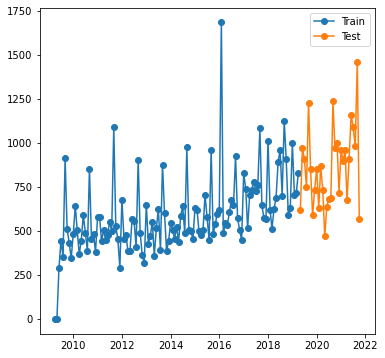

In [ ]:
# Divide il dataset in Train e Test per i licenziamenti
train_San_Assunzioni,test_San_Assunzioni = Split_df(df_San,"VALUE_x",0.8)

In [ ]:
Build_Model(train_San_Assunzioni,2,3,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1437.859, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1430.283, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1442.679, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1439.812, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1426.325, Time=0.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1424.363, Time=0.48 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1428.408, Time=0.23 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1426.331, Time=0.64 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1427.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  121
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -708.182
Date:                  Thu, 19 May 2022   AIC                           1424.363
Time:                          11:46:44   BIC                           1435.128
Sample:                               0   HQIC                          1428.729
                                  - 121                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     64.9448     23.798      2.729      0.006      18.301     111.589
ar.S.L12      -0.4154      0.044     -9.498      0.000      -0.501      -0.330
ar.S.L24      -0.2382      0.064     -3.739      0.000      -0.363      -0.113
sigma2      2.513e+04   1399.350     17.955      0.000    2.24e+04    2.79e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1552.50
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             2.52
Prob(H) (two-sided):                  0.28   Kurtosis:                        20.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

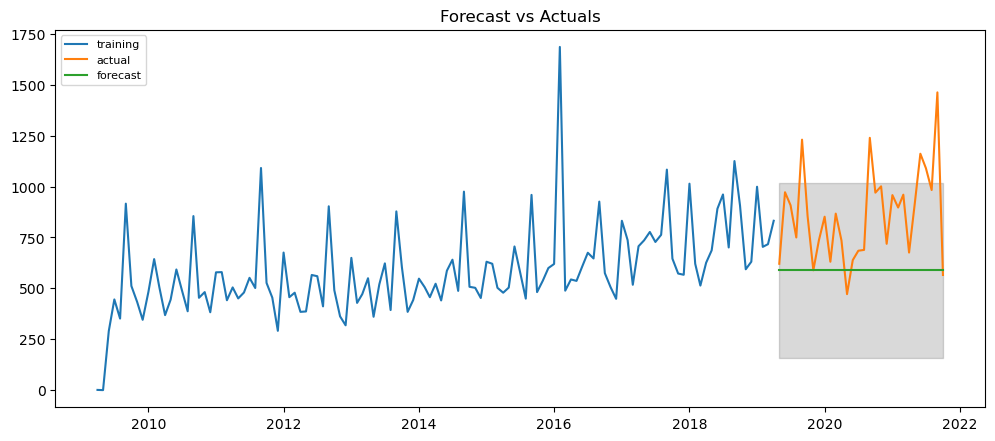

In [ ]:
pred_San_Ass_Arima = Predict(train_San_Assunzioni,test_San_Assunzioni,0,0,0,30)

In [ ]:
# Printa le metriche di valutazione per il modello Arima
Evaluation_Metrics(test_San_Assunzioni,pred_San_Ass_Arima)

RMSE: 351.669381


As before, the arima model did not have the desired effect.

 It is probably just the wrong model. SARIMAX performs better

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91210D+00    |proj g|=  3.42995D-02

At iterate    5    f=  5.91138D+00    |proj g|=  3.92396D-04

At iterate   10    f=  5.91133D+00    |proj g|=  7.09291D-03

At iterate   15    f=  5.91106D+00    |proj g|=  1.03077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   1.035D-06   5.911D+00
  F =   5.9110572539937660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


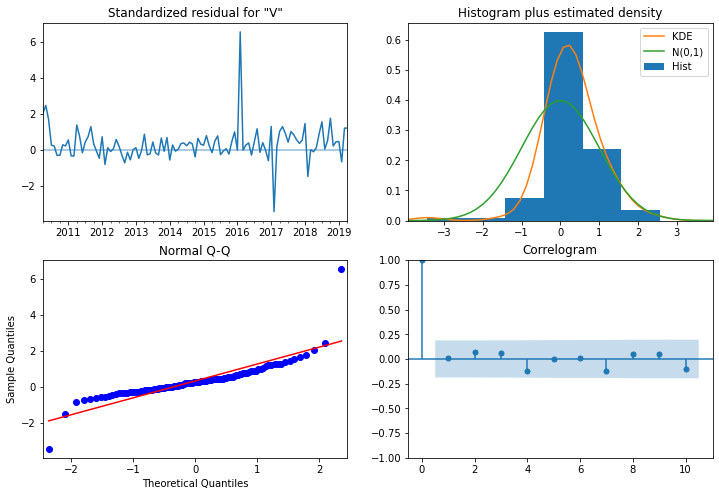

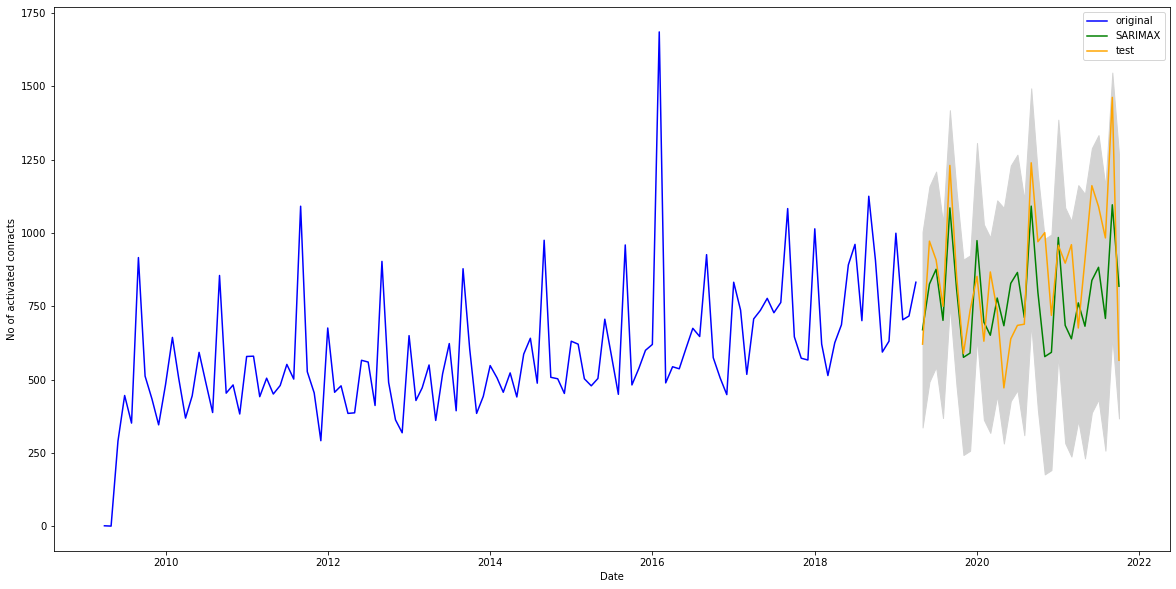

In [ ]:
# Implementazione SARIMAX
pred_San_Ass_Sarima = Go_Sarimax(train_San_Assunzioni,test_San_Assunzioni,"VALUE_x",30,0,0,0,2,1,0,12)

In [ ]:
# Printa le metriche di valutazione per il modello sarima
Evaluation_Metrics(test_San_Assunzioni,pred_San_Ass_Sarima.predicted_mean)

RMSE: 193.736538


## 7.2 - Layoffs Forecasting

In [ ]:
# Ricava valori ottimai per p e q per i licenziamenti
Studio_Arima(df_San_1,"VALUE_y")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68537D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   6.685D+00
  F =   6.6853726406669480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42737D+00    |proj g|=  4.08143D-02

At iterate    5    f=  6.40237D+00    |proj g|=  1.21742D-02

At iterate   10    f=  6.39933D+00    |proj g|=  2.17515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   8.882D-08   6.399D+00
  F =   6.3993281552201386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.39526D+00    |proj g|=  1.50990D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   0.000D+00   6.395D+00
  F =   6.3952639710375099     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41677D+00    |proj g|=  3.82163D-02

At iterate    5    f=  6.39469D+00    |proj g|=  5.36717D-03


 This problem is unconstrained.



At iterate   10    f=  6.39112D+00    |proj g|=  7.64242D-03

At iterate   15    f=  6.39033D+00    |proj g|=  3.01092D-05

At iterate   20    f=  6.39033D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   8.882D-08   6.390D+00
  F =   6.3903258753430299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59428D+00    |proj g|=  1.37419D-03



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  6.59428D+00    |proj g|=  6.48370D-06

At iterate   10    f=  6.59428D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     19      1     0     0   8.882D-08   6.594D+00
  F =   6.5942769576079829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44342D+00    |proj g|=  4.19820D-02

At iterate    5    f=  6.41814D+00    |proj g|=  4.60876D-03

At itera

 This problem is unconstrained.



At iterate    5    f=  6.40883D+00    |proj g|=  6.33884D-03

At iterate   10    f=  6.40315D+00    |proj g|=  1.18838D-03

At iterate   15    f=  6.40311D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   8.882D-08   6.403D+00
  F =   6.4031133980976076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42394D+00    |proj g|=  3.68750D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  6.39518D+00    |proj g|=  5.89928D-04

At iterate   15    f=  6.39511D+00    |proj g|=  5.50315D-04

At iterate   20    f=  6.39510D+00    |proj g|=  2.39808D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   8.882D-08   6.395D+00
  F =   6.3951014329716633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37742D+00    |proj g|=  3.56758D-02

At iterate    5    f=  6.35639D+00    |proj g|=  1.04422D-02

At iterate   10    f=  6.35388D+00    |proj g|=  6.92868D-04

At iterate   15    f=  6.35379D+00    |proj g|=  1.60725D-03

At iterate   20    f=  6.35378D+00    |proj g|=  2.66454D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     33      1     0     0   1.776D-07   6.354D+00
  F =   6.3537779644011492     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42136D+00    |proj g|=  4.16189D-02

At iterate    5    f=  6.40933D+00    |proj g|=  2.22515D-03

At iterate   10    f=  6.40895D+00    |proj g|=  3.66818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.776D-07   6.409D+00
  F =   6.4089494252528763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  6.39293D+00    |proj g|=  2.15188D-03

At iterate   15    f=  6.39287D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   8.882D-08   6.393D+00
  F =   6.3928716941606041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32768D+00    |proj g|=  3.93881D-02


 This problem is unconstrained.



At iterate    5    f=  6.31772D+00    |proj g|=  4.39957D-02

At iterate   10    f=  6.31391D+00    |proj g|=  1.39469D-02

At iterate   15    f=  6.31244D+00    |proj g|=  1.56676D-02

At iterate   20    f=  6.30918D+00    |proj g|=  1.74879D-02

At iterate   25    f=  6.30895D+00    |proj g|=  1.04956D-03

At iterate   30    f=  6.30892D+00    |proj g|=  9.04965D-04

At iterate   35    f=  6.30891D+00    |proj g|=  1.10134D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     73      2     0     0   1.688D-06   6.309D+00
  F =   6.3089143378494610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29311D+00    |proj g|=  1.71042D-01

At iterate    5    f=  6.28403D+00    |proj g|=  7.81858D-02

At iterate   10    f=  6.26681D+00    |proj g|=  3.92700D-02

At iterate   15    f=  6.26483D+00    |proj g|=  4.22832D-02

At iterate   20    f=  6.26102D+00    |proj g|=  3.04792D-02

At iterate   25    f=  6.26077D+00    |proj g|=  6.89919D-03

At iterate   30    f=  6.26045D+00    |proj g|=  1.44436D-03

At iterate   35    f=  6.26040D+00    |proj g|=  1.34407D-02

At iterate   40    f=  6.26014D+00    |proj g|=  7.87121D-03

At iterate   45    f=  6.26013D+00    |proj g|=  1.68932D-04

At iterate   50    f=  6.26013D+00    |proj g|=  4.17444D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.27644D+00    |proj g|=  1.27769D-01

At iterate   10    f=  6.26281D+00    |proj g|=  4.91879D-02

At iterate   15    f=  6.25899D+00    |proj g|=  1.73732D-02

At iterate   20    f=  6.25583D+00    |proj g|=  1.99479D-02

At iterate   25    f=  6.25530D+00    |proj g|=  5.56497D-03

At iterate   30    f=  6.25446D+00    |proj g|=  3.23936D-02

At iterate   35    f=  6.25388D+00    |proj g|=  3.61595D-03

At iterate   40    f=  6.25370D+00    |proj g|=  5.08118D-03

At iterate   45    f=  6.25349D+00    |proj g|=  8.21823D-03

At iterate   50    f=  6.25348D+00    |proj g|=  2.96243D-03

At iterate   55    f=  6.25344D+00    |proj g|=  1.75646D-03

At iterate   60    f=  6.25342D+00    |proj g|=  1.84066D-03

At iterate   65    f=  6.25339D+00    |proj g|=  5.94831D-03

At iterate   70    f=  6.25335D+00    |proj g|=  4.60689D-03

At iterate   75    f=  6.25332D+00    |proj g|=  2.35687D-03

At iterate   80    f=  6.25331D+00    |proj g|=  9.97868D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  305    f=  6.25324D+00    |proj g|=  5.68434D-06

At iterate  310    f=  6.25324D+00    |proj g|=  1.42109D-05

At iterate  315    f=  6.25324D+00    |proj g|=  4.79616D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8    318    422      2     0     0   1.155D-06   6.253D+00
  F =   6.2532430854908760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45415D+00    |proj g|=  1.85105D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42345D+00    |proj g|=  8.61152D-02

At iterate    5    f=  6.39475D+00    |proj g|=  5.70433D-03

At iterate   10    f=  6.39080D+00    |proj g|=  6.46949D-04

At iterate   15    f=  6.39068D+00    |proj g|=  3.93161D-03

At iterate   20    f=  6.39030D+00    |proj g|=  4.14424D-04


 This problem is unconstrained.



At iterate   25    f=  6.39029D+00    |proj g|=  8.77520D-05

At iterate   30    f=  6.39028D+00    |proj g|=  2.39808D-05

At iterate   35    f=  6.39028D+00    |proj g|=  1.79412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     58      1     0     0   2.842D-06   6.390D+00
  F =   6.3902846511168976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39580D+00    |proj g|=  4.04918D-02

At iterate    5    f=  6.38358D+00    |proj g|=  1.68038D-02

At iterate   10    f=  6.37966D+00    |proj g|=  7.60636D-04

At iterate   15    f=  6.37962D+00    |proj g|=  2.77023D-04

At iterate   20    f=  6.37962D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     29      1     0     0   2.665D-07   6.380D+00
  F =   6.3796150181358007     

CONVERG

 This problem is unconstrained.



At iterate   30    f=  6.26660D+00    |proj g|=  3.42055D-03

At iterate   35    f=  6.26653D+00    |proj g|=  1.21480D-02

At iterate   40    f=  6.26635D+00    |proj g|=  1.31690D-02

At iterate   45    f=  6.26618D+00    |proj g|=  4.34781D-03

At iterate   50    f=  6.26616D+00    |proj g|=  3.18998D-03

At iterate   55    f=  6.26613D+00    |proj g|=  6.68710D-03

At iterate   60    f=  6.26611D+00    |proj g|=  4.07336D-03

At iterate   65    f=  6.26610D+00    |proj g|=  5.07683D-04

At iterate   70    f=  6.26610D+00    |proj g|=  8.27516D-04

At iterate   75    f=  6.26609D+00    |proj g|=  1.96954D-03

At iterate   80    f=  6.26609D+00    |proj g|=  9.02212D-04

At iterate   85    f=  6.26609D+00    |proj g|=  1.24567D-03

At iterate   90    f=  6.26609D+00    |proj g|=  1.28138D-03

At iterate   95    f=  6.26609D+00    |proj g|=  4.56701D-04

At iterate  100    f=  6.26609D+00    |proj g|=  4.04299D-04

At iterate  105    f=  6.26609D+00    |proj g|=  2.83062D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28760D+00    |proj g|=  1.15826D-01

At iterate    5    f=  6.27937D+00    |proj g|=  5.32671D-02

At iterate   10    f=  6.26248D+00    |proj g|=  9.88008D-02

At iterate   15    f=  6.25954D+00    |proj g|=  6.66165D-02

At iterate   20    f=  6.25859D+00    |proj g|=  1.31548D-03

At iterate   25    f=  6.25848D+00    |proj g|=  1.01279D-03

At iterate   30    f=  6.25848D+00    |proj g|=  7.25109D-04

At iterate   35    f=  6.25848D+00    |proj g|=  2.76579D-04

At iterate   40    f=  6.25848D+00    |proj g|=  3.99529D-03

At iterate   45    f=  6.25845D+00    |proj g|=  5.24709D-03

At iterate   50    f=  6.25838D+00    |proj g|=  8.31220D-03

At iterate   55    f=  6.25830D+00    |proj g|=  9.99361D-03

At iterate   60    f=  6.25814D+00    |proj g|=  7.25526D-03

At iterate   65    f=  6.2

 This problem is unconstrained.



At iterate   10    f=  6.26845D+00    |proj g|=  2.55483D-02

At iterate   15    f=  6.26369D+00    |proj g|=  1.15332D-02

At iterate   20    f=  6.26127D+00    |proj g|=  5.24417D-02

At iterate   25    f=  6.26060D+00    |proj g|=  1.98570D-02

At iterate   30    f=  6.26009D+00    |proj g|=  1.01829D-02

At iterate   35    f=  6.26008D+00    |proj g|=  2.89546D-04

At iterate   40    f=  6.26005D+00    |proj g|=  3.01652D-03

At iterate   45    f=  6.26003D+00    |proj g|=  2.25917D-03

At iterate   50    f=  6.25994D+00    |proj g|=  1.79543D-02

At iterate   55    f=  6.25975D+00    |proj g|=  1.12972D-02

At iterate   60    f=  6.25964D+00    |proj g|=  3.76676D-03

At iterate   65    f=  6.25955D+00    |proj g|=  4.66187D-03

At iterate   70    f=  6.25951D+00    |proj g|=  3.38947D-03

At iterate   75    f=  6.25950D+00    |proj g|=  2.30393D-03

At iterate   80    f=  6.25950D+00    |proj g|=  1.25500D-04

At iterate   85    f=  6.25950D+00    |proj g|=  3.72147D-05

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42835D+00    |proj g|=  2.91883D-02

At iterate    5    f=  6.42684D+00    |proj g|=  4.90630D-04

At iterate   10    f=  6.42663D+00    |proj g|=  4.94964D-03

At iterate   15    f=  6.42643D+00    |proj g|=  5.39124D-05

At iterate   20    f=  6.42643D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   1.776D-07   6.426D+00
  F =   6.4264336251120753     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37176D+00    |proj g|=  6.37015D-02

At iterate    5    f=  6.35875D+00    |proj g|=  1.28590D-03

At iterate   10    f=  6.35860D+00    |proj g|=  6.79723D-04

At iterate   15    f=  6.35858D+00    |proj g|=  2.66454D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     21      1     0     0   8.882D-08   6.359D+00
  F =   6.3585827026593078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36963D+00    |proj g|=  5.15758D-02

At iterate    5    f=  6.35885D+00    |proj g|=  6.69393D-03

At iterate   10    f=  6.35840D+00    |proj g|=  7.99716D-04

At iterate   15    f=  6.35836D+00    |proj g|=  5.53246D-04

At iterate   20    f=  6.35835D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   1.776D-07   6.358D+00
  F =   6.3583549893823728     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26795D+00    |proj g|=  2.59207D-01

At iterate    5    f=  6.26015D+00    |proj g|=  4.97003D-02

At iterate   10    f=  6.25340D+00    |proj g|=  2.24150D-02

At iterate   15    f=  6.25120D+00    |proj g|=  7.02522D-03

At iterate   20    f=  6.25035D+00    |proj g|=  2.05809D-02

At iterate   25    f=  6.24969D+00    |proj g|=  2.61773D-03

At iterate   30    f=  6.24967D+00    |proj g|=  2.39666D-03

At iterate   35    f=  6.24963D+00    |proj g|=  3.39906D-04

At iterate   40    f=  6.24963D+00    |proj g|=  6.93134D-04

At iterate   45    f=  6.24963D+00    |proj g|=  2.57572D-05

At iterate   50    f=  6.24963D+00    |proj g|=  1.63425D-05

At iterate   55    f=  6.24963D+00    |proj g|=  1.15463D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27259D+00    |proj g|=  2.35456D-01

At iterate    5    f=  6.26220D+00    |proj g|=  6.77471D-02

At iterate   10    f=  6.25689D+00    |proj g|=  9.24452D-03

At iterate   15    f=  6.25532D+00    |proj g|=  2.82947D-03

At iterate   20    f=  6.25480D+00    |proj g|=  6.12145D-02

At iterate   25    f=  6.25438D+00    |proj g|=  7.56923D-03

At iterate   30    f=  6.25418D+00    |proj g|=  1.10099D-03

At iterate   35    f=  6.25399D+00    |proj g|=  2.63418D-02

At iterate   40    f=  6.25387D+00    |proj g|=  1.34079D-03

At iterate   45    f=  6.25364D+00    |proj g|=  1.21264D-02

At iterate   50    f=  6.25292D+00    |proj g|=  6.84324D-03

At iterate   55    f=  6.25159D+00    |proj g|=  2.03416D-02

At iterate   60    f=  6.25051D+00    |proj g|=  1.66938D-02

At iterate   65    f=  6.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26961D+00    |proj g|=  2.37545D-01

At iterate    5    f=  6.25872D+00    |proj g|=  5.85716D-02

At iterate   10    f=  6.25350D+00    |proj g|=  1.72759D-02

At iterate   15    f=  6.25171D+00    |proj g|=  1.64581D-02

At iterate   20    f=  6.25131D+00    |proj g|=  1.54920D-02

At iterate   25    f=  6.25084D+00    |proj g|=  1.89443D-02

At iterate   30    f=  6.25032D+00    |proj g|=  6.73728D-03

At iterate   35    f=  6.25022D+00    |proj g|=  9.25962D-03

At iterate   40    f=  6.25010D+00    |proj g|=  3.21272D-03

At iterate   45    f=  6.25006D+00    |proj g|=  2.78888D-03

At iterate   50    f=  6.25005D+00    |proj g|=  1.91696D-03

At iterate   55    f=  6.25004D+00    |proj g|=  1.30882D-03

At iterate   60    f=  6.25000D+00    |proj g|=  1.18163D-03

At iterate   65    f=  6.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33709D+00    |proj g|=  2.18317D-02

At iterate    5    f=  6.33305D+00    |proj g|=  6.21636D-04

At iterate   10    f=  6.33299D+00    |proj g|=  2.29905D-03

At iterate   15    f=  6.33279D+00    |proj g|=  1.09095D-03

At iterate   20    f=  6.33279D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   8.882D-08   6.333D+00
  F =   6.3327906207701412     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.31892D+00    |proj g|=  5.18963D-03

At iterate   10    f=  6.31878D+00    |proj g|=  1.05249D-03

At iterate   15    f=  6.31870D+00    |proj g|=  7.95426D-03

At iterate   20    f=  6.31858D+00    |proj g|=  4.69846D-05

At iterate   25    f=  6.31858D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   1.776D-07   6.319D+00
  F =   6.3185813423905604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40542D+00    |proj g|=  4.26519D-02

At iterate    5    f=  6.36374D+00    |proj g|=  1.49683D-02

At iterate   10    f=  6.35982D+00    |proj g|=  2.95568D-03

At iterate   15    f=  6.35967D+00    |proj g|=  4.39195D-03

At iterate   20    f=  6.35965D+00    |proj g|=  2.09104D-03

At iterate   25    f=  6.35965D+00    |proj g|=  1.61604D-03
  ys=-2.876E-07  -gs= 7.984E-08 BFGS update SKIPPED
  ys=-5.288E-12  -gs= 1.075E-11 BFGS update SKIPPED

At iterate   30    f=  6.35965D+00    |proj g|=  3.13891D-03

At iterate   35    f=  6.35965D+00    |proj g|=  1.75264D-03

At iterate   40    f=  6.35965D+00    |proj g|=  1.25313D-03

At iterate   45    f=  6.35965D+00    |proj g|=  1.43165D-03

At iterate   50    f=  6.35965D+00    |proj g|=  9.48219D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  6.35964D+00    |proj g|=  2.01172D-03

At iterate   60    f=  6.35962D+00    |proj g|=  3.15108D-03
  ys=-1.355E-06  -gs= 5.593E-07 BFGS update SKIPPED

At iterate   65    f=  6.35962D+00    |proj g|=  2.14744D-03

At iterate   70    f=  6.35962D+00    |proj g|=  2.06173D-03

At iterate   75    f=  6.35962D+00    |proj g|=  1.95941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     78    270      2     3     0   7.208D-04   6.360D+00
  F =   6.3596171146100016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26169D+00    |proj g|=  1.31286D-01

At iterate    5    f=  6.25035D+00    |proj g|=  9.59304D-03

At iterate   10    f=  6.24876D+00    |proj g|=  1.69980D-02

At iterate   15    f=  6.24820D+00    |proj g|=  2.17321D-02

At iterate   20    f=  6.24812D+00    |proj g|=  3.54294D-04

At iterate   25    f=  6.24811D+00    |proj g|=  5.59819D-04

At iterate   30    f=  6.24811D+00    |proj g|=  4.36096D-05

At iterate   35    f=  6.24811D+00    |proj g|=  3.46390D-06

At iterate   40    f=  6.24811D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  6.26034D+00    |proj g|=  1.68700D-02

At iterate   15    f=  6.25745D+00    |proj g|=  1.25643D-02

At iterate   20    f=  6.25569D+00    |proj g|=  1.84120D-02

At iterate   25    f=  6.25490D+00    |proj g|=  3.34087D-02

At iterate   30    f=  6.25334D+00    |proj g|=  8.13731D-03

At iterate   35    f=  6.25287D+00    |proj g|=  1.03526D-02

At iterate   40    f=  6.25268D+00    |proj g|=  3.18048D-03

At iterate   45    f=  6.25188D+00    |proj g|=  6.95159D-03

At iterate   50    f=  6.25130D+00    |proj g|=  4.03026D-02

At iterate   55    f=  6.25098D+00    |proj g|=  1.67756D-02

At iterate   60    f=  6.25087D+00    |proj g|=  9.41007D-03

At iterate   65    f=  6.25084D+00    |proj g|=  2.95204D-03

At iterate   70    f=  6.25082D+00    |proj g|=  3.39639D-03

At iterate   75    f=  6.25082D+00    |proj g|=  7.57403D-03

At iterate   80    f=  6.25079D+00    |proj g|=  9.13811D-03

At iterate   85    f=  6.25077D+00    |proj g|=  1.35606D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  175    f=  6.25066D+00    |proj g|=  3.49027D-03

At iterate  180    f=  6.25066D+00    |proj g|=  1.44560D-03
  ys=-1.277E-09  -gs= 6.642E-09 BFGS update SKIPPED

At iterate  185    f=  6.25066D+00    |proj g|=  2.19886D-03

At iterate  190    f=  6.25066D+00    |proj g|=  1.63078D-03

At iterate  195    f=  6.25066D+00    |proj g|=  2.23119D-03

At iterate  200    f=  6.25066D+00    |proj g|=  2.07505D-03

At iterate  205    f=  6.25066D+00    |proj g|=  2.07878D-03

At iterate  210    f=  6.25066D+00    |proj g|=  1.57403D-03

At iterate  215    f=  6.25066D+00    |proj g|=  1.94094D-03
  ys=-2.095E-09  -gs= 5.322E-09 BFGS update SKIPPED

At iterate  220    f=  6.25066D+00    |proj g|=  1.02007D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  225    f=  6.25066D+00    |proj g|=  8.53628D-04

At iterate  230    f=  6.25066D+00    |proj g|=  3.28360D-03

At iterate  235    f=  6.25066D+00    |proj g|=  1.47660D-03

At iterate  240    f=  6.25066D+00    |proj g|=  3.04450D-03
  ys=-7.662E-09  -gs= 1.064E-09 BFGS update SKIPPED

At iterate  245    f=  6.25066D+00    |proj g|=  2.53157D-03

At iterate  250    f=  6.25066D+00    |proj g|=  2.12523D-03

At iterate  255    f=  6.25066D+00    |proj g|=  2.15810D-03
  ys=-1.109E-10  -gs= 1.276E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  260    f=  6.25066D+00    |proj g|=  2.33795D-03

At iterate  265    f=  6.25065D+00    |proj g|=  1.00115D-03

At iterate  270    f=  6.25065D+00    |proj g|=  2.70015D-03

At iterate  275    f=  6.25065D+00    |proj g|=  1.01128D-03

At iterate  280    f=  6.25065D+00    |proj g|=  3.32623D-03

At iterate  285    f=  6.25065D+00    |proj g|=  1.94982D-03

At iterate  290    f=  6.25065D+00    |proj g|=  2.28022D-03

At iterate  295    f=  6.25065D+00    |proj g|=  2.11333D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  300    f=  6.25065D+00    |proj g|=  1.37463D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  305    f=  6.25065D+00    |proj g|=  1.81108D-03

At iterate  310    f=  6.25065D+00    |proj g|=  1.28093D-03

At iterate  315    f=  6.25064D+00    |proj g|=  1.24851D-03

At iterate  320    f=  6.25064D+00    |proj g|=  2.53904D-03

At iterate  325    f=  6.25064D+00    |proj g|=  2.27400D-03
  ys=-1.798E-11  -gs= 2.232E-11 BFGS update SKIPPED

At iterate  330    f=  6.25064D+00    |proj g|=  1.28395D-03
  ys=-4.997E-10  -gs= 3.169E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  335    f=  6.25064D+00    |proj g|=  2.75380D-03

At iterate  340    f=  6.25064D+00    |proj g|=  1.96403D-03

At iterate  345    f=  6.25064D+00    |proj g|=  2.36131D-03

At iterate  350    f=  6.25063D+00    |proj g|=  7.52935D-03
  ys=-9.635E-13  -gs= 1.215E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  355    f=  6.25062D+00    |proj g|=  1.59623D-03

At iterate  360    f=  6.25062D+00    |proj g|=  3.66773D-03

At iterate  365    f=  6.25062D+00    |proj g|=  7.41274D-04

At iterate  370    f=  6.25061D+00    |proj g|=  4.73648D-03

At iterate  375    f=  6.25061D+00    |proj g|=  1.29567D-03

At iterate  380    f=  6.25061D+00    |proj g|=  1.65183D-03

At iterate  385    f=  6.25061D+00    |proj g|=  2.44285D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  390    f=  6.25061D+00    |proj g|=  3.71818D-03

At iterate  395    f=  6.25061D+00    |proj g|=  3.34373D-03

At iterate  400    f=  6.25060D+00    |proj g|=  2.57474D-03

At iterate  405    f=  6.25060D+00    |proj g|=  5.00959D-03

At iterate  410    f=  6.25060D+00    |proj g|=  1.49063D-03

At iterate  415    f=  6.25060D+00    |proj g|=  2.62066D-03
  ys=-1.808E-10  -gs= 9.098E-08 BFGS update SKIPPED

At iterate  420    f=  6.25060D+00    |proj g|=  2.46656D-03

At iterate  425    f=  6.25060D+00    |proj g|=  2.70877D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  430    f=  6.25060D+00    |proj g|=  9.81704D-04

At iterate  435    f=  6.25060D+00    |proj g|=  1.27214D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  440    f=  6.25060D+00    |proj g|=  9.80460D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  445    f=  6.25060D+00    |proj g|=  2.87734D-03

At iterate  450    f=  6.25060D+00    |proj g|=  1.57856D-03

At iterate  455    f=  6.25060D+00    |proj g|=  1.20091D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  460    f=  6.25060D+00    |proj g|=  2.46434D-03

At iterate  465    f=  6.25059D+00    |proj g|=  1.18987D-02

At iterate  470    f=  6.25058D+00    |proj g|=  1.71578D-03

At iterate  475    f=  6.25058D+00    |proj g|=  8.82441D-03

At iterate  480    f=  6.25057D+00    |proj g|=  2.30056D-03

At iterate  485    f=  6.25057D+00    |proj g|=  1.55280D-03

At iterate  490    f=  6.25057D+00    |proj g|=  1.84608D-03

At iterate  495    f=  6.25057D+00    |proj g|=  2.71463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10    495   1415     13     8     0   2.715D-03   6.251D+00
  F =   6.25057151023

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28981D+00    |proj g|=  9.06628D-02

At iterate    5    f=  6.27036D+00    |proj g|=  7.19055D-02

At iterate   10    f=  6.26136D+00    |proj g|=  1.20518D-02

At iterate   15    f=  6.25955D+00    |proj g|=  1.00352D-02

At iterate   20    f=  6.25664D+00    |proj g|=  1.27971D-02

At iterate   25    f=  6.25496D+00    |proj g|=  7.01566D-02

At iterate   30    f=  6.25354D+00    |proj g|=  7.71809D-03

At iterate   35    f=  6.25150D+00    |proj g|=  7.96900D-03

At iterate   40    f=  6.25062D+00    |proj g|=  1.22346D-02

At iterate   45    f=  6.25044D+00    |proj g|=  2.62306D-03

At iterate   50    f=  6.25004D+00    |proj g|=  2.07940D-02

At iterate   55    f=  6.24971D+00    |proj g|=  8.50839D-03

At iterate   60    f=  6.24962D+00    |proj g|=  2.85238D-03

At iterate   65    f=  6.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   90    f=  6.24951D+00    |proj g|=  2.31744D-03

At iterate   95    f=  6.24951D+00    |proj g|=  1.76872D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  100    f=  6.24951D+00    |proj g|=  3.34826D-03

At iterate  105    f=  6.24951D+00    |proj g|=  1.95159D-03

At iterate  110    f=  6.24951D+00    |proj g|=  2.43103D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  115    f=  6.24948D+00    |proj g|=  6.03340D-03

At iterate  120    f=  6.24947D+00    |proj g|=  5.90186D-03

At iterate  125    f=  6.24947D+00    |proj g|=  1.60432D-03

At iterate  130    f=  6.24947D+00    |proj g|=  3.04787D-03
  ys=-4.599E-14  -gs= 6.482E-14 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  135    f=  6.24947D+00    |proj g|=  3.02371D-03

At iterate  140    f=  6.24947D+00    |proj g|=  7.32481D-04

At iterate  145    f=  6.24947D+00    |proj g|=  2.28537D-03

At iterate  150    f=  6.24947D+00    |proj g|=  3.11475D-03

At iterate  155    f=  6.24947D+00    |proj g|=  2.51168D-03

At iterate  160    f=  6.24947D+00    |proj g|=  2.56115D-03

At iterate  165    f=  6.24947D+00    |proj g|=  2.54676D-03
  ys=-2.254E-09  -gs= 7.179E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    167    460      5     2     0   2.683D-03   6.249D+00
  F =   6.2494664137577187     

,p,q,aic,bic,sum_aic_bic
0,0,0,2009.611792,2015.633063,4025.244855
6,1,0,1984.283087,1993.314993,3977.59808
18,3,0,1945.971871,1961.025048,3906.996919
12,2,0,1944.059243,1956.101784,3900.161026
24,4,0,1939.930088,1957.993899,3897.923987
7,1,1,1933.310295,1945.352836,3878.663132
2,0,2,1933.030548,1945.073089,3878.103637
13,2,1,1932.684828,1947.738004,3880.422832
10,1,4,1932.53043,1953.604877,3886.135307
1,0,1,1931.928787,1940.960693,3872.88948


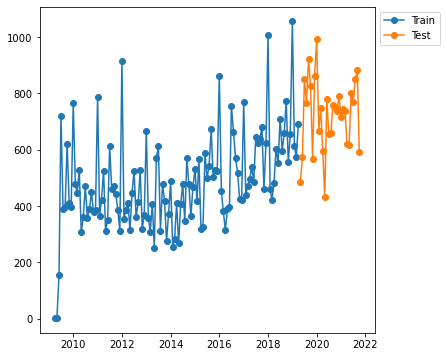

In [ ]:
# Divide il dataset in Train e Test per i licenziamenti
train_San_Licenziamenti,test_San_Licenziamenti = Split_df(df_San_1,"VALUE_y",0.8)

In [ ]:
# Estrazione del modello
Build_Model(train_San_Licenziamenti,4,3,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1355.283, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1362.953, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1349.228, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1347.457, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1367.172, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1356.443, Time=0.11 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1351.081, Time=0.25 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1342.407, Time=0.45 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1356.965, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -666.203
Date:                            Thu, 19 May 2022   AIC                           1342.407
Time:                                    11:47:52   BIC                           1355.863
Sample:                                         0   HQIC                          1347.864
                                            - 121                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4008      3.450      1.276      0.202      -2.360      11.162
ar.L1          0.8645      0.117      7.421      0.000       0.636       1.093
ma.L1         -0.5976      0.177     -3.385      0.001      -0.944      -0.252
ma.S.L12      -0.7661      0.102     -7.481      0.000      -0.967      -0.565
sigma2      1.094e+04   1392.309      7.857      0.000    8210.992    1.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 4.79
Prob(Q):                              0.59   Prob(JB):                         0.09
Heteroskedasticity (H):               0.63   Skew:                             0.01
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

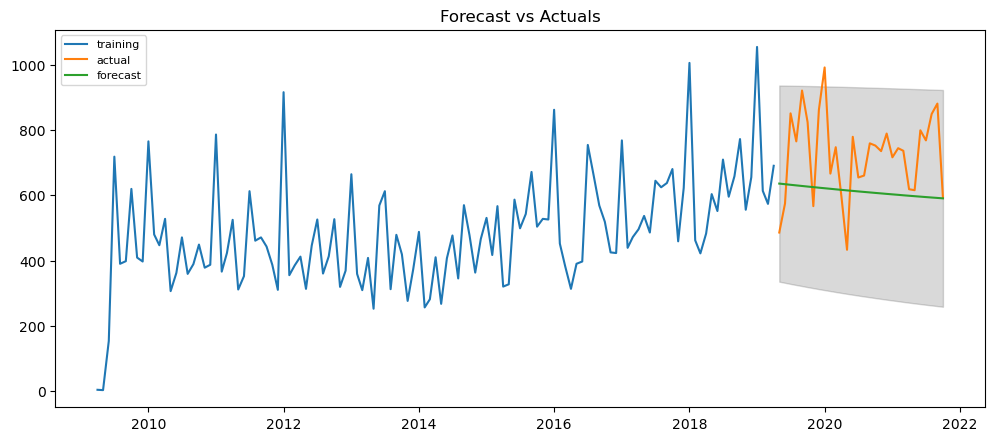

In [ ]:
# Applicazione del modello estratto in precedenza
pred_San_Lic_Arima = Predict(train_San_Licenziamenti,test_San_Licenziamenti,1,0,1,30)

In [ ]:
# Printa le metriche di valutazione per il modello Arima
Evaluation_Metrics(test_San_Licenziamenti,pred_San_Lic_Arima)

RMSE: 170.294740


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57996D+00    |proj g|=  1.96318D-01

At iterate    5    f=  5.55066D+00    |proj g|=  7.52530D-02

At iterate   10    f=  5.52706D+00    |proj g|=  1.00156D-02


 This problem is unconstrained.



At iterate   15    f=  5.52325D+00    |proj g|=  8.16250D-04

At iterate   20    f=  5.52302D+00    |proj g|=  3.91879D-05

At iterate   25    f=  5.52301D+00    |proj g|=  2.40091D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   4.909D-06   5.523D+00
  F =   5.5230120160126610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


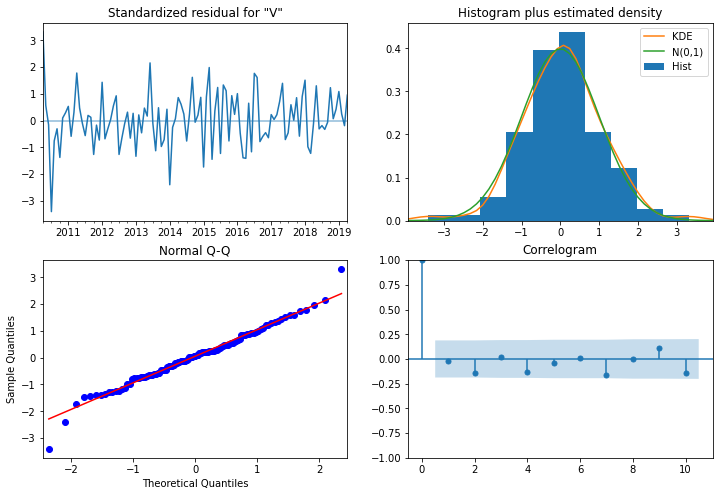

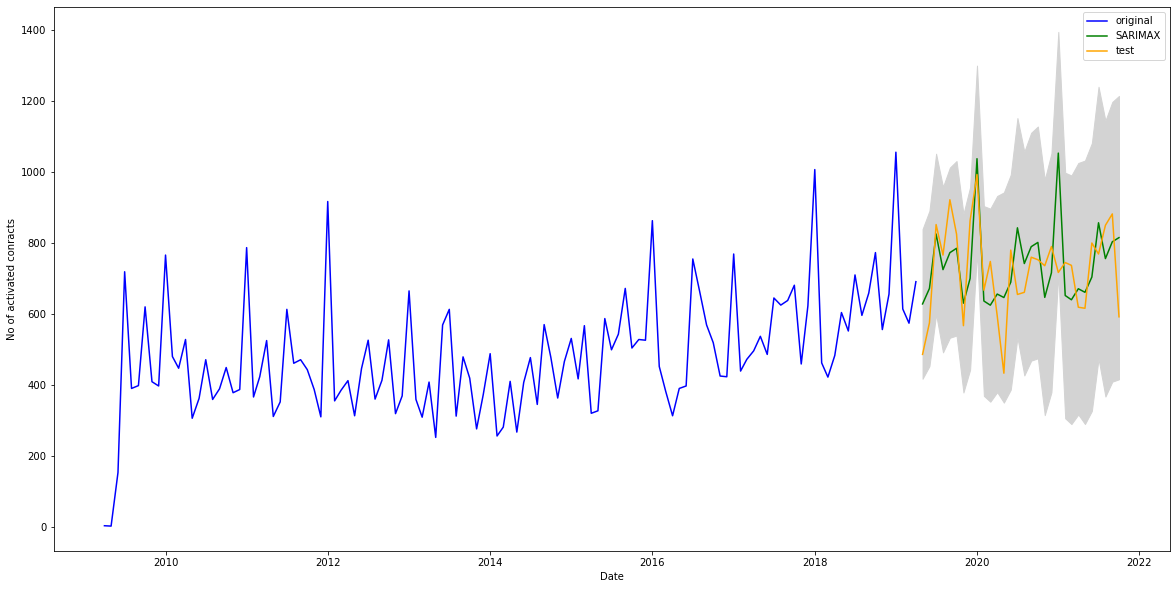

In [ ]:
# Applicazione di SARIMAX
pred_San_Lic_Sarima = Go_Sarimax(train_San_Licenziamenti,test_San_Licenziamenti,"VALUE_y",30,1,0,1,0,1,1,12)

In [ ]:
# Printa le metriche di valutazione per il modello sarima
Evaluation_Metrics(test_San_Licenziamenti,pred_San_Lic_Sarima.predicted_mean)

RMSE: 120.870025
